# Market Basket Analysis with RFM analysis

Market Basket Analysis decodes customer purchasing patterns through transactional data, revealing item associations.
When integrated with RFM analysis, businesses gain a holistic understanding to alter strategies and enhance customer
satisfaction. Our project merges Market Basket Analysis and RFM (Recency, Frequency, Monetary Value)
Analysis to decode customer purchasing patterns. This combined approach uncovers correlations
in product purchases and customer behavior, empowering us to tailor strategies for enhanced
customer satisfaction. By leveraging these insights, we aim to optimize product placement,
marketing strategies, and promotions to meet diverse customer preferences, fostering stronger
relationships and loyalty

Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans #For customer segmentation
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import time
warnings.filterwarnings("ignore")

In [ ]:
#Proprocessing the dataset
df1 = pd.read_excel('/content/online_retail_09_10.xlsx')
df2 = pd.read_excel('/content/online_retail_10_11.xlsx')
df = pd.concat([df1, df2])
df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909  581587      POST                              POSTAGE         1   

               InvoiceDate  Price  Customer ID         Country  
0      2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3      2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4      2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
...                    ...    ...          ...             ...  
541905 2011-12-09 12:50:00   2.10      12680.0          France  
541906 2011-12-09 12:50:00   4.15      12680.0          France  
541907 2011-12-09 12:50:00   4.15      12680.0          France  
541908 2011-12-09 12:50:00   4.95      12680.0          France  
541909 2011-12-09 12:50:00  18.00      12680.0          France  

[1067371 rows x 8 columns]

##### Understanding the dataset

In this dataset we have the following rows

1. InvoiceNo: Invoice number. <br>
2. StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
3. Description: Product (item) name. Nominal. <br>
4. Quantity: The quantities of each product (item) per transaction. Numeric.	<br>
5. InvoiceDate: Invoice date and time. Numeric. The day and time when a transaction was generated. <br>
6. UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
7. CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. <br>
8. Country: Country name. Nominal. The name of the country where a customer resides. <br>

In [ ]:
print(f"Shape of the dataframe : {df.shape}")
print(f"Number of transactions : {df.shape[0]}")
print(f"Number of features used : {df.shape[1]}")

Shape of the dataframe : (1067371, 8)
Number of transactions : 1067371
Number of features used : 8


### Datatype of each column

In [ ]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

* The invoice date is in the correct datetime format
* Customer ID can be converted to int/str instead of float as it constitutes of only numbers - for that we'll have to check if it contains NULL values



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


### Check for NULL values

Here we can see that the 'Description' and 'Customer ID' columns have null values.

In [ ]:
# Check how many columns have null values in Description and Customer ID
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [ ]:
# Display the columns where Customer ID is Null
df[df['Customer ID'].isna()]

Invoice StockCode                     Description  Quantity  \
263     489464     21733                    85123a mixed       -96   
283     489463     71477                           short      -240   
284     489467    85123A                     21733 mixed      -192   
470     489521     21646                             NaN       -50   
577     489525    85226C       BLUE PULL BACK RACING CAR         1   
...        ...       ...                             ...       ...   
541536  581498    85099B         JUMBO BAG RED RETROSPOT         5   
541537  581498    85099C  JUMBO  BAG BAROQUE BLACK WHITE         4   
541538  581498     85150   LADIES & GENTLEMEN METAL SIGN         1   
541539  581498     85174               S/4 CACTI CANDLES         1   
541540  581498       DOT                  DOTCOM POSTAGE         1   

               InvoiceDate    Price  Customer ID         Country  
263    2009-12-01 10:52:00     0.00          NaN  United Kingdom  
283    2009-12-01 10:52:00     0.00          NaN  United Kingdom  
284    2009-12-01 10:53:00     0.00          NaN  United Kingdom  
470    2009-12-01 11:44:00     0.00          NaN  United Kingdom  
577    2009-12-01 11:49:00     0.55          NaN  United Kingdom  
...                    ...      ...          ...             ...  
541536 2011-12-09 10:26:00     4.13          NaN  United Kingdom  
541537 2011-12-09 10:26:00     4.13          NaN  United Kingdom  
541538 2011-12-09 10:26:00     4.96          NaN  United Kingdom  
541539 2011-12-09 10:26:00    10.79          NaN  United Kingdom  
541540 2011-12-09 10:26:00  1714.17          NaN  United Kingdom  

[243007 rows x 8 columns]

In [ ]:
df.dropna(subset = 'Customer ID', axis=0, inplace = True)
print(f'Shape after removing null values from the dataset : {df.shape}')

Shape after removing null values from the dataset : (824364, 8)


In [ ]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

There are no missing values now

### Check for negative values

In [ ]:
df.describe()

Quantity          Price    Customer ID
count  824364.000000  824364.000000  824364.000000
mean       12.414574       3.676800   15324.638504
std       188.976099      70.241388    1697.464450
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13975.000000
50%         5.000000       1.950000   15255.000000
75%        12.000000       3.750000   16797.000000
max     80995.000000   38970.000000   18287.000000

The above table indicated there are negative values in the 'Quantity' and 'Price' column. We'll have to remove those as these indicate cancelled or returned products

In [ ]:
# These many columns contain negative values
df[(df['Quantity'] <= 0)]

Invoice StockCode                       Description  Quantity  \
178     C489449     22087          PAPER BUNTING WHITE LACE       -12   
179     C489449    85206A      CREAM FELT EASTER EGG BASKET        -6   
180     C489449     21895     POTTING SHED SOW 'N' GROW SET        -4   
181     C489449     21896                POTTING SHED TWINE        -6   
182     C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12   
...         ...       ...                               ...       ...   
540449  C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541  C581499         M                            Manual        -1   
541715  C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716  C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717  C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate   Price  Customer ID         Country  
178    2009-12-01 10:33:00    2.95      16321.0       Australia  
179    2009-12-01 10:33:00    1.65      16321.0       Australia  
180    2009-12-01 10:33:00    4.25      16321.0       Australia  
181    2009-12-01 10:33:00    2.10      16321.0       Australia  
182    2009-12-01 10:33:00    2.95      16321.0       Australia  
...                    ...     ...          ...             ...  
540449 2011-12-09 09:57:00    0.83      14397.0  United Kingdom  
541541 2011-12-09 10:28:00  224.69      15498.0  United Kingdom  
541715 2011-12-09 11:57:00   10.95      15311.0  United Kingdom  
541716 2011-12-09 11:58:00    1.25      17315.0  United Kingdom  
541717 2011-12-09 11:58:00    1.25      17315.0  United Kingdom  

[18744 rows x 8 columns]

In [ ]:
df['Invoice'].str.contains('C').sum()

18744

In [ ]:
df = df[~df['Invoice'].str.contains('C', na=False)]
df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909  581587      POST                              POSTAGE         1   

               InvoiceDate  Price  Customer ID         Country  
0      2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3      2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4      2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
...                    ...    ...          ...             ...  
541905 2011-12-09 12:50:00   2.10      12680.0          France  
541906 2011-12-09 12:50:00   4.15      12680.0          France  
541907 2011-12-09 12:50:00   4.15      12680.0          France  
541908 2011-12-09 12:50:00   4.95      12680.0          France  
541909 2011-12-09 12:50:00  18.00      12680.0          France  

[805620 rows x 8 columns]

In [ ]:
df['Description'] = df['Description'].str.strip()

We have taken care of all the negative values in the dataframe

### Remove duplicate values

In [ ]:
df.duplicated().sum()

26125

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909  581587      POST                              POSTAGE         1   

               InvoiceDate  Price  Customer ID         Country  
0      2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3      2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4      2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
...                    ...    ...          ...             ...  
541905 2011-12-09 12:50:00   2.10      12680.0          France  
541906 2011-12-09 12:50:00   4.15      12680.0          France  
541907 2011-12-09 12:50:00   4.15      12680.0          France  
541908 2011-12-09 12:50:00   4.95      12680.0          France  
541909 2011-12-09 12:50:00  18.00      12680.0          France  

[779495 rows x 8 columns]

Now, our data is free of all missing values, duplicate values, and negative values

### Check for Outliers

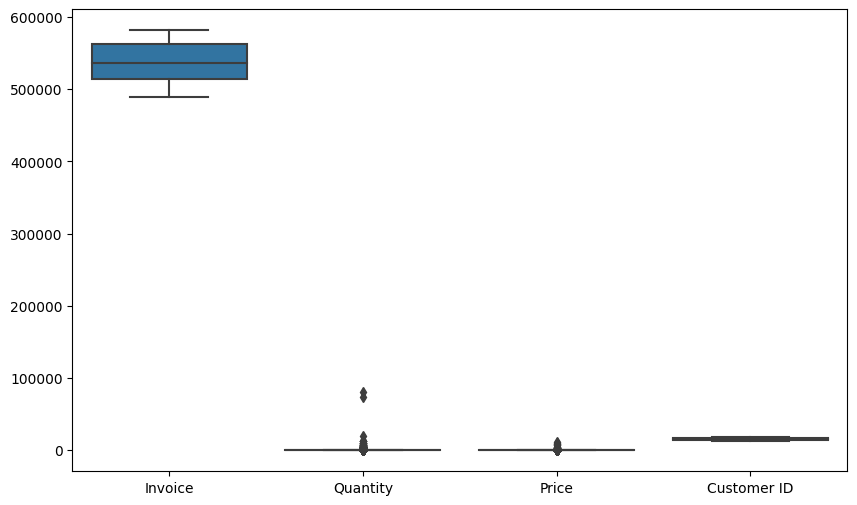

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df)
plt.show()

From the above boxplot and based on df.describe, there exists outliers in the Quantity and Price column

In [ ]:
# We'll remove only the extreme outliers as we have lost enough data already
Q1 = df[['Quantity', 'Price']].quantile(0.01)
Q3 = df[['Quantity', 'Price']].quantile(0.99)
IQR = Q3 - Q1

df_outliers = df[((df[['Quantity', 'Price']] < (Q1 - 1.5 * IQR)) | (df[['Quantity', 'Price']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df_outliers

Invoice StockCode                    Description  Quantity  \
126     489444      POST                        POSTAGE         1   
173     489447      POST                        POSTAGE         1   
217     489460     84598  BOYS ALPHABET IRON ON PATCHES       576   
575     489523     84879  ASSORTED COLOUR BIRD ORNAMENT       800   
1344    489562     84472  PINK AND LILAC QUILTED THROW          1   
...        ...       ...                            ...       ...   
537883  581375     21137       BLACK RECORD COVER FRAME       960   
540061  581457     23543            WALL ART KEEP CALM        698   
540070  581458     22197                 POPCORN HOLDER      1500   
540071  581459     22197                 POPCORN HOLDER      1200   
540421  581483     23843    PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate   Price  Customer ID         Country  
126    2009-12-01 09:55:00  141.00      12636.0             USA  
173    2009-12-01 10:10:00  130.00      12362.0         Belgium  
217    2009-12-01 10:46:00    0.21      16167.0  United Kingdom  
575    2009-12-01 11:46:00    1.45      12931.0  United Kingdom  
1344   2009-12-01 13:07:00   45.95      17998.0  United Kingdom  
...                    ...     ...          ...             ...  
537883 2011-12-08 12:36:00    3.39      16210.0  United Kingdom  
540061 2011-12-08 18:43:00    4.15      18102.0  United Kingdom  
540070 2011-12-08 18:45:00    0.72      17949.0  United Kingdom  
540071 2011-12-08 18:46:00    0.72      17949.0  United Kingdom  
540421 2011-12-09 09:15:00    2.08      16446.0  United Kingdom  

[3104 rows x 8 columns]

In [ ]:
df = df.drop(df_outliers.index)
df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909  581587      POST                              POSTAGE         1   

               InvoiceDate  Price  Customer ID         Country  
0      2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2      2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3      2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4      2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
...                    ...    ...          ...             ...  
541905 2011-12-09 12:50:00   2.10      12680.0          France  
541906 2011-12-09 12:50:00   4.15      12680.0          France  
541907 2011-12-09 12:50:00   4.15      12680.0          France  
541908 2011-12-09 12:50:00   4.95      12680.0          France  
541909 2011-12-09 12:50:00  18.00      12680.0          France  

[774156 rows x 8 columns]

In [ ]:
df.describe()

Quantity          Price    Customer ID
count  774156.000000  774156.000000  774156.000000
mean       11.343552       2.899091   15320.665366
std        22.896442       2.926629    1694.962047
min         1.000000       0.000000   12346.000000
25%         2.000000       1.250000   13975.000000
50%         6.000000       1.950000   15249.000000
75%        12.000000       3.750000   16794.000000
max       352.000000      36.800000   18287.000000

In [ ]:
#Final shape of the dataset
print(f' Final shape of the dataset : {df.shape}')

 Final shape of the dataset : (774156, 8)


### EDA to answer some Key questions

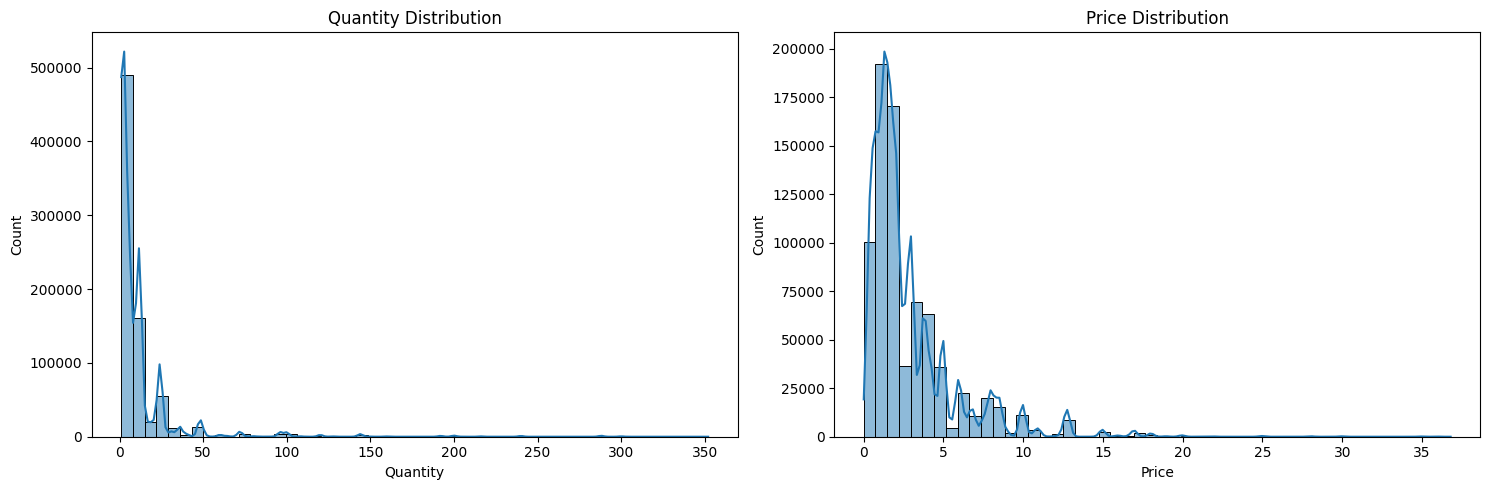

In [ ]:
figs, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['Quantity'], bins = 50, kde = True, ax = axes[0])
axes[0].set_title('Quantity Distribution')

sns.histplot(df['Price'], bins = 50, kde = True, ax = axes[1])
axes[1].set_title('Price Distribution')

plt.tight_layout()
plt.show()

* We can see that the consumers buy things in lower quantity more (especially in the range of 1 - 10) <br>
* Also the consumers tend to buy more things in the lower price range

#### 1. Top 20 products based on Quantity sold

In [ ]:
product_quantity = df.groupby(df['Description'])['Quantity'].sum().reset_index()
sorted_product_quantity = product_quantity.sort_values(by = 'Quantity', ascending = False)
# Let's get the top 20 products that are brought by consumers
top_20_products = sorted_product_quantity.head(20)

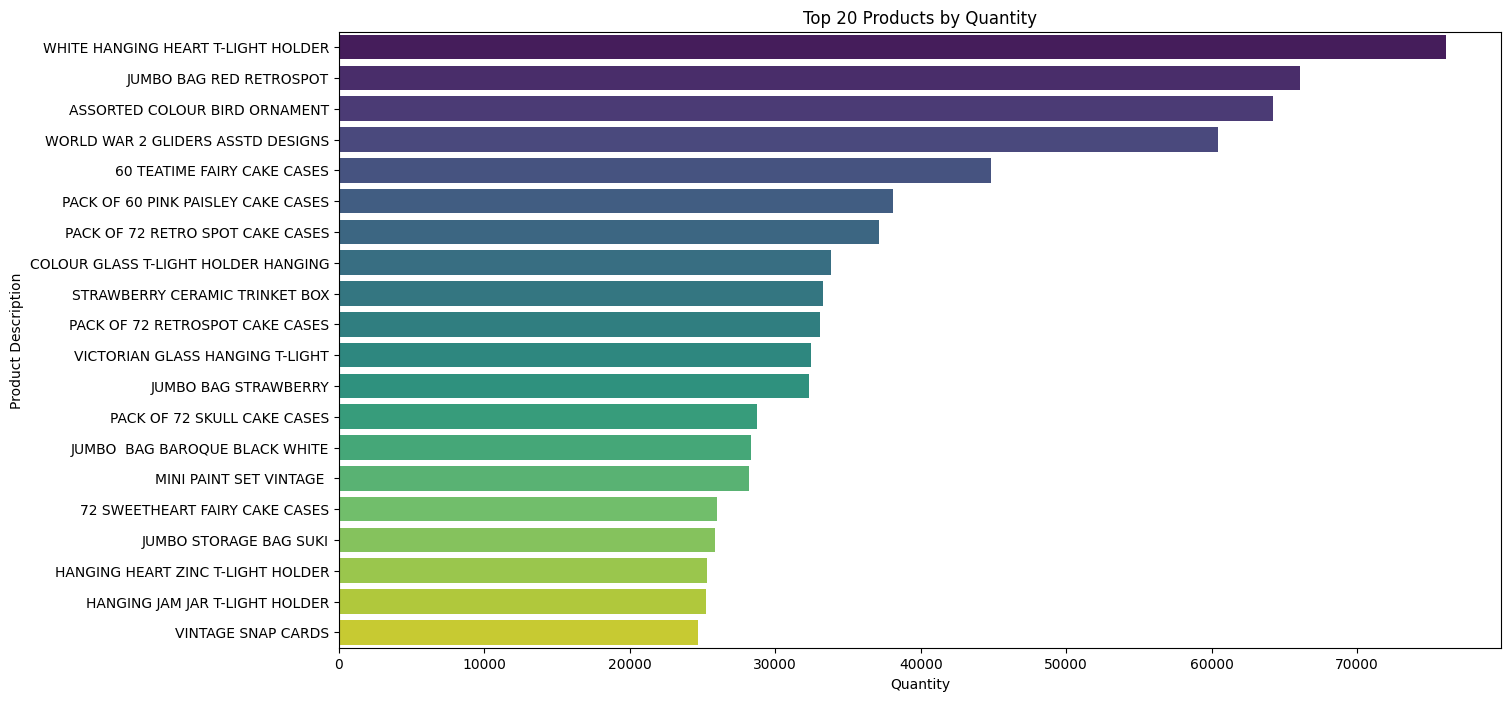

In [ ]:
# Plot the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Quantity', y='Description', data=top_20_products, palette='viridis')
plt.title(f'Top 20 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Description')
plt.show()

#### 2. Least sold products

In [ ]:
product_quantity = df.groupby(df['Description'])['Quantity'].sum().reset_index()
sorted_product_quantity = product_quantity.sort_values(by = 'Quantity', ascending = True)
# Let's get the top 20 products that are brought by consumers
low_20_products = sorted_product_quantity.head(20)

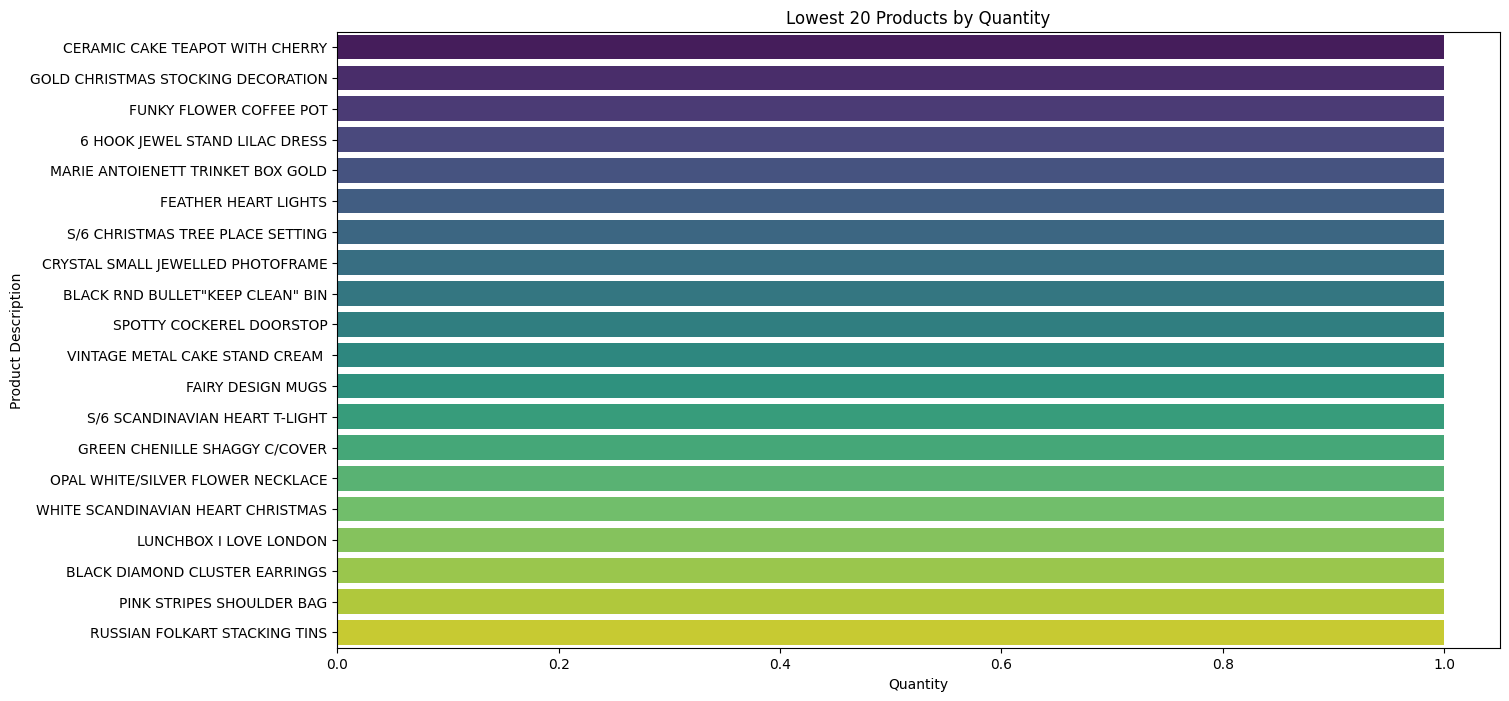

In [ ]:
# Plot the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Quantity', y='Description', data=low_20_products, palette='viridis')
plt.title(f'Lowest 20 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Description')
plt.show()

In [ ]:
low_20_products.Description

910        CERAMIC CAKE TEAPOT WITH CHERRY
1991    GOLD CHRISTMAS STOCKING DECORATION
1861               FUNKY FLOWER COFFEE POT
145         6 HOOK JEWEL STAND LILAC DRESS
2670     MARIE ANTOIENETT TRINKET BOX GOLD
1614                  FEATHER HEART LIGHTS
3981      S/6 CHRISTMAS TREE PLACE SETTING
1191     CRYSTAL SMALL JEWELLED PHOTOFRAME
510       BLACK RND BULLET"KEEP CLEAN" BIN
4553              SPOTTY COCKEREL DOORSTOP
4895       VINTAGE METAL CAKE STAND CREAM 
1597                     FAIRY DESIGN MUGS
3988        S/6 SCANDINAVIAN HEART T-LIGHT
2029         GREEN CHENILLE SHAGGY C/COVER
2950     OPAL WHITE/SILVER FLOWER NECKLACE
5051    WHITE SCANDINAVIAN HEART CHRISTMAS
2623                LUNCHBOX I LOVE LONDON
477         BLACK DIAMOND CLUSTER EARRINGS
3437             PINK STRIPES SHOULDER BAG
3922         RUSSIAN FOLKART STACKING TINS
Name: Description, dtype: object

In [ ]:
df[df['Description'] == 'WHITE SCANDINAVIAN HEART CHRISTMAS']

Invoice StockCode                         Description  Quantity  \
14026  490512    35976B  WHITE SCANDINAVIAN HEART CHRISTMAS         1   

              InvoiceDate  Price  Customer ID         Country  
14026 2009-12-06 14:54:00   1.25      14606.0  United Kingdom

#### 3. Top 10 countries based on total transactions and amount spent in sales

In [ ]:
df['Amount'] = df['Quantity'] * df['Price']

In [ ]:
country_sales = df.groupby('Country')['Amount'].sum().reset_index()
country_sales = country_sales.sort_values(by = 'Amount', ascending=False)
top_10_country_sales = country_sales.head(10)
top_10_country_sales

Country        Amount
38  United Kingdom  1.289280e+07
10            EIRE  5.600062e+05
24     Netherlands  5.037647e+05
14         Germany  4.173126e+05
13          France  3.176805e+05
0        Australia  1.581344e+05
32           Spain  9.362368e+04
34     Switzerland  9.326504e+04
33          Sweden  7.423948e+04
3          Belgium  6.320734e+04

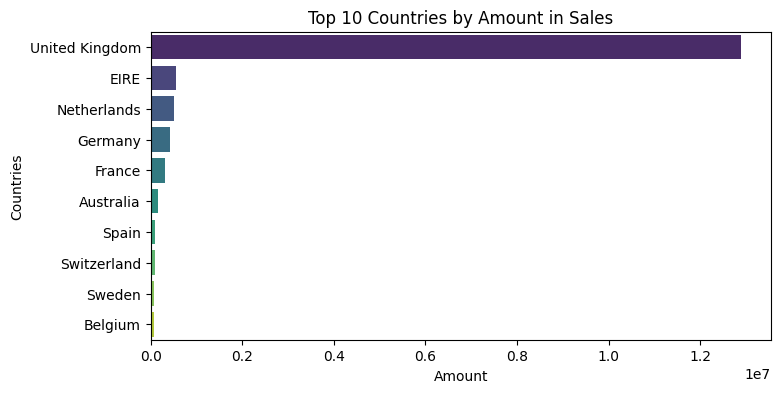

In [ ]:
# Plot the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Amount', y='Country', data=top_10_country_sales, palette='viridis')
plt.title(f'Top 10 Countries by Amount in Sales')
plt.xlabel('Amount')
plt.ylabel('Countries')
plt.show()

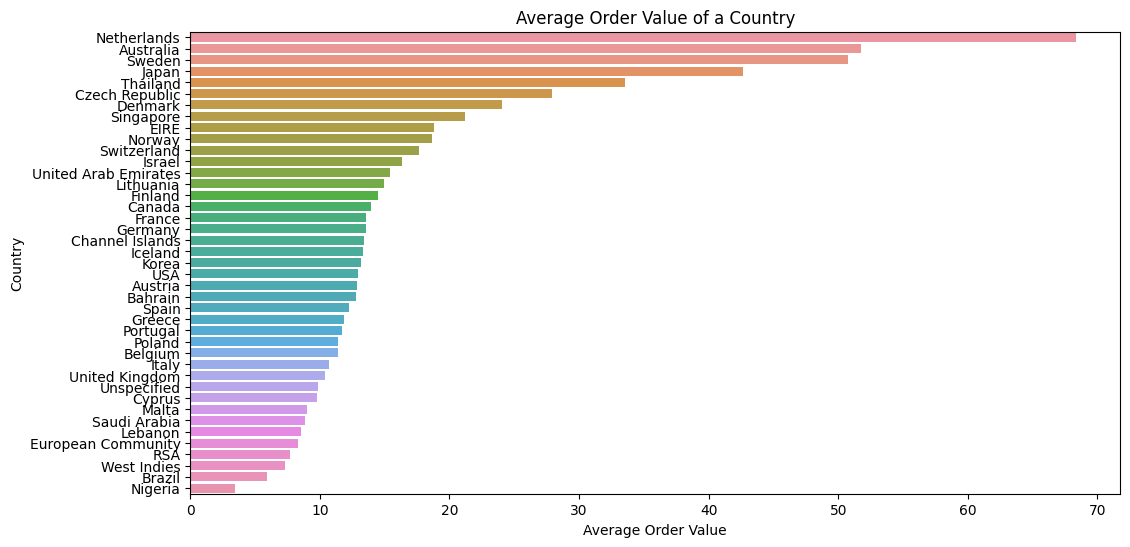

In [ ]:
country_mean = df.groupby('Country')['Quantity'].mean().reset_index()
sorted_country_mean = country_mean.sort_values(by = 'Quantity', ascending = False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Country', data=sorted_country_mean)
plt.title('Average Order Value of a Country')
plt.xlabel('Average Order Value')
plt.ylabel('Country')
plt.show()

#### 4. Top 10 selling products based on the month

In [ ]:
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

In [ ]:
sales_by_month = df.groupby('Month')['Quantity'].sum().reset_index()

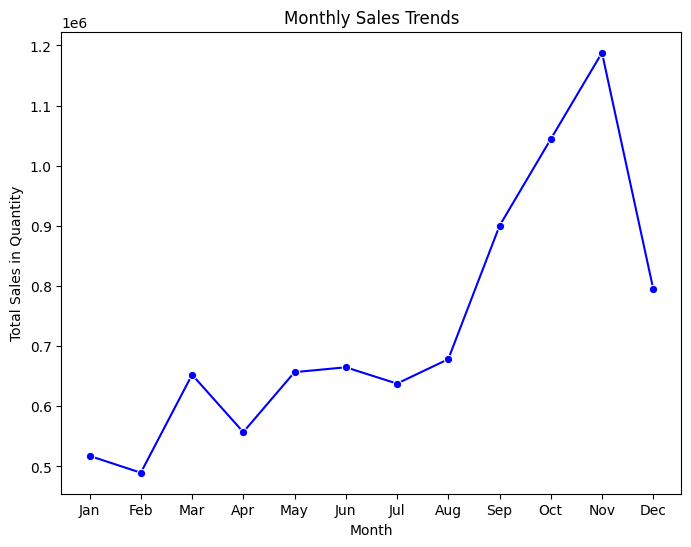

In [ ]:
# Plot the monthly sales trends
plt.figure(figsize=(8, 6))
sns.lineplot(x='Month', y='Quantity', data=sales_by_month, marker='o', color='blue')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales in Quantity')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

We can see that there is huge rise in sale of products around second half of the year, especially during October and November, which is also holiday season. Let's further analyze which products are sold more in each month as this would help in planning the inventory

#### 5. Top products on monthly-basis as this would help us maintain the inventory

In [ ]:
# Group by month and product description, calculate total sales, and rank products
monthly_top_products = (
    df.groupby(['Month', 'Description'])
    .agg({'Quantity': 'sum'})
    .reset_index())

In [ ]:
# Rank products within each month based on total sales
monthly_top_products['Rank'] = monthly_top_products.groupby('Month')['Quantity'].rank(ascending=False, method='dense')

In [ ]:
# Filter to get the top N products in each month (adjust N as needed)
top_n = 3
monthly_top_n_products = monthly_top_products[monthly_top_products['Rank'] <= top_n]

# Display the top products in each month
print(monthly_top_n_products)

       Month                          Description  Quantity  Rank
109        1          60 TEATIME FAIRY CAKE CASES      3523   3.0
111        1       72 SWEETHEART FAIRY CAKE CASES      4424   2.0
3132       1   WHITE HANGING HEART T-LIGHT HOLDER      6545   1.0
3373       2          60 TEATIME FAIRY CAKE CASES      4302   2.0
5174       2     PACK OF 72 RETRO SPOT CAKE CASES      3734   3.0
6417       2   WHITE HANGING HEART T-LIGHT HOLDER      4641   1.0
6655       3          60 TEATIME FAIRY CAKE CASES      4790   3.0
6739       3        ASSORTED COLOUR BIRD ORNAMENT      5571   2.0
9854       3   WHITE HANGING HEART T-LIGHT HOLDER      5934   1.0
10164      4        ASSORTED COLOUR BIRD ORNAMENT      5073   2.0
10690      4  COLOUR GLASS T-LIGHT HOLDER HANGING      3748   3.0
13084      4   WHITE HANGING HEART T-LIGHT HOLDER      5393   1.0
13944      5  COLOUR GLASS T-LIGHT HOLDER HANGING      5370   2.0
16370      5   WHITE HANGING HEART T-LIGHT HOLDER      7143   1.0
16444     

In [ ]:
monthly_top_n_products['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     11
ASSORTED COLOUR BIRD ORNAMENT           6
JUMBO BAG RED RETROSPOT                 6
WORLD WAR 2 GLIDERS ASSTD DESIGNS       5
60 TEATIME FAIRY CAKE CASES             3
COLOUR GLASS T-LIGHT HOLDER HANGING     2
72 SWEETHEART FAIRY CAKE CASES          1
PACK OF 72 RETRO SPOT CAKE CASES        1
RABBIT NIGHT LIGHT                      1
Name: Description, dtype: int64

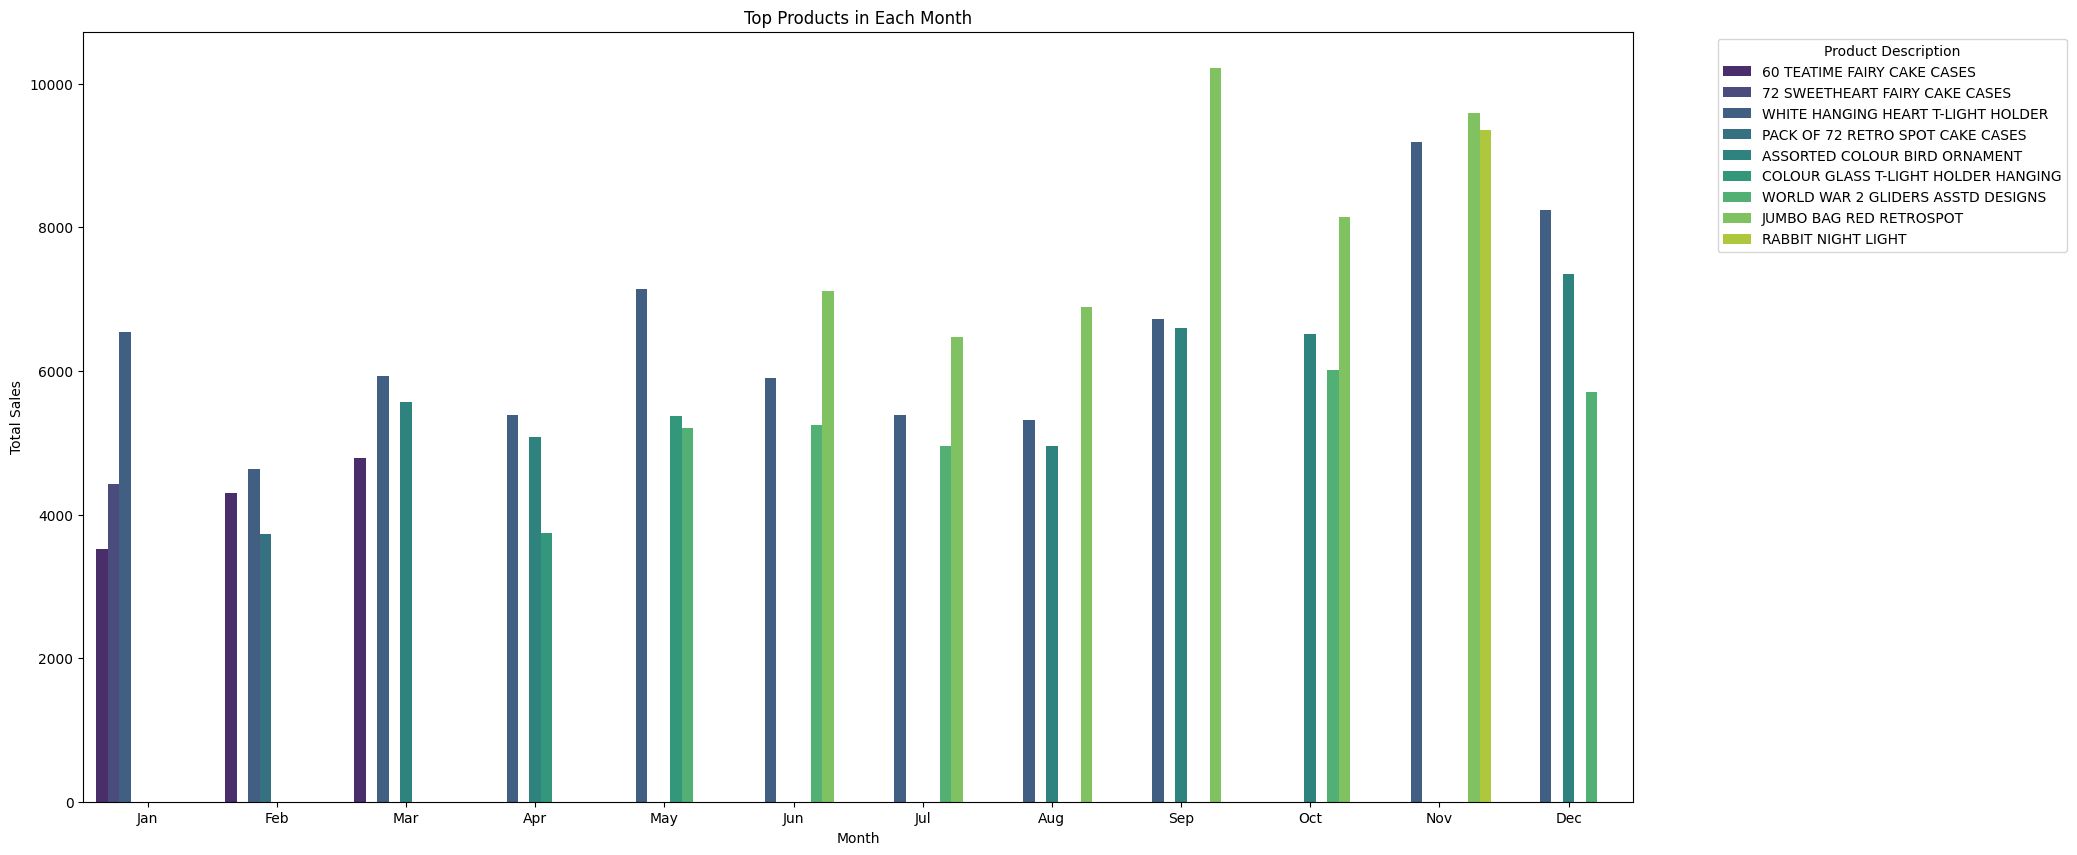

In [ ]:
plt.figure(figsize=(20,10))

# Create a grouped bar plot
sns.barplot(x='Month', y='Quantity', hue='Description', data=monthly_top_n_products, palette='viridis')

# Add labels and title
plt.title('Top Products in Each Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Product Description', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

Insights - <br>
* 60 TEATIME FAIRY CAKE CASES - is being sold more mainly in the first 3 months of the year (Spring) <br>
* WHITE HANGING HEART T-LIGHT HOLDER - is one of their best selling products, as it is bought in huge volumes all year around <br>
* ASSORTED COLOUR BIRD ORNAMENT - is sold mainly in the second half of the year
* JUMBO BAG RED RETROSPOT - is sold abundantly in the months from June to November, peaking in the month of September

#### 6. Top products sold based on the Country the consumers buy from

In [ ]:
# Group by country and product description, calculate total sales, and rank products
countrywise_top_products = (
    df.groupby(['Country', 'Description'])
    .agg({'Quantity': 'sum'})
    .reset_index())

In [ ]:
countrywise_top_products

Country                        Description  Quantity
0        Australia                  DOLLY GIRL BEAKER       200
1        Australia        I LOVE LONDON MINI BACKPACK         4
2        Australia             10 COLOUR SPACEBOY PEN        48
3        Australia   12 PENCILS SMALL TUBE RED SPOTTY        24
4        Australia          12 PENCILS TALL TUBE POSY       252
...            ...                                ...       ...
29210  West Indies           VINTAGE BEAD PINK SCARF          3
29211  West Indies  WHITE AND BLUE CERAMIC OIL BURNER         6
29212  West Indies   WOODLAND PARTY BAG + STICKER SET         1
29213  West Indies       WOVEN BERRIES CUSHION COVER          2
29214  West Indies          WOVEN FROST CUSHION COVER         2

[29215 rows x 3 columns]

In [ ]:
# Rank products within each country based on total sales
countrywise_top_products['Rank'] = countrywise_top_products.groupby('Country')['Quantity'].rank(ascending=False, method='dense')

In [ ]:
# Filter to get the top N products in each country (adjust N as needed)
top_n = 1
countrywise_top_products = countrywise_top_products[countrywise_top_products['Rank'] <= top_n]

# Display the top products in each month
countrywise_top_products

Country                          Description  Quantity  \
176               Australia                 DOLLY GIRL LUNCH BOX      1316   
1293                Austria     SET 12 KIDS COLOUR  CHALK STICKS       288   
1428                Bahrain           ICE CREAM SUNDAE LIP GLOSS        96   
1726                Belgium                 DOLLY GIRL LUNCH BOX       572   
2554                 Brazil                 DOLLY GIRL LUNCH BOX        25   
2557                 Brazil                DRAGONS BLOOD INCENSE        25   
2832                 Canada    WORLD WAR 2 GLIDERS ASSTD DESIGNS       288   
2868        Channel Islands             AFGHAN SLIPPER SOCK PAIR       600   
3986                 Cyprus       HEART DECORATION PAINTED ZINC        384   
4510         Czech Republic   WOODEN STAR CHRISTMAS SCANDINAVIAN        72   
4511         Czech Republic   WOODEN TREE CHRISTMAS SCANDINAVIAN        72   
4666                Denmark                    GUMBALL COAT RACK       354   
5030                   EIRE          60 TEATIME FAIRY CAKE CASES      4020   
7991     European Community       RED ROCKING HORSE HAND PAINTED        24   
7992     European Community       ROCKING HORSE GREEN CHRISTMAS         24   
7993     European Community         ROCKING HORSE RED CHRISTMAS         24   
8005     European Community  SET OF 60 PANTRY DESIGN CAKE CASES         24   
8006     European Community   SET OF 60 VINTAGE LEAF CAKE CASES         24   
8011     European Community     WHITE ROCKING HORSE HAND PAINTED        24   
8141                Finland      CHILDRENS CUTLERY POLKADOT PINK       480   
9683                 France              MINI PAINT SET VINTAGE       3168   
12542               Germany  ROUND SNACK BOXES SET OF4 WOODLAND       2668   
13704                Greece   WHITE HANGING HEART T-LIGHT HOLDER       160   
13773               Iceland           ICE CREAM SUNDAE LIP GLOSS       240   
14123                Israel               WOODLAND CHARLOTTE BAG       120   
14384                 Italy                 FEATHER PEN,HOT PINK       432   
15106                 Japan       PACK OF 12 TRADITIONAL CRAYONS       481   
15266                 Korea                CACTI T-LIGHT CANDLES        48   
15278                 Korea                 HEART T-LIGHT HOLDER        48   
15308                 Korea   TROPICAL  HONEYCOMB PAPER GARLAND         48   
15314               Lebanon   ASSTD FRUIT+FLOWERS FRIDGE MAGNETS        24   
15412             Lithuania     GOLD MUG BONE CHINA TREE OF LIFE        72   
15461             Lithuania   SILVER MUG BONE CHINA TREE OF LIFE        72   
15588                 Malta                GRAND CHOCOLATECANDLE       153   
16899           Netherlands                  SPACEBOY LUNCH BOX       4988   
17061               Nigeria                     EMPIRE GIFT WRAP        25   
17085               Nigeria               WRAP PINK FAIRY CAKES         25   
17661                Norway  SMALL FOLDING SCISSOR(POINTED EDGE)       576   
18026                Poland       STRAWBERRY CERAMIC TRINKET BOX       240   
18469              Portugal    JUMBO SHOPPER VINTAGE RED PAISLEY       330   
19045                   RSA          12 PENCILS SMALL TUBE SKULL        24   
19161                   RSA               WOODEN BOX OF DOMINOES        24   
19166          Saudi Arabia        ASSORTED BOTTLE TOP  MAGNETS         12   
19171          Saudi Arabia         HOMEMADE JAM SCENTED CANDLES        12   
19172          Saudi Arabia       PLASTERS IN TIN CIRCUS PARADE         12   
19173          Saudi Arabia               PLASTERS IN TIN SKULLS        12   
19174          Saudi Arabia            PLASTERS IN TIN STRONGMAN        12   
19222             Singapore         CHRISTMAS TREE PAINTED ZINC        384   
19514                 Spain        ASSORTED COLOUR BIRD ORNAMENT      1009   
20923                Sweden          60 TEATIME FAIRY CAKE CASES      3024   
22331           Switzerland     PLASTERS I

#### 7. Time-Series Analysis - Visualize monthly, daily and hourly sales trend

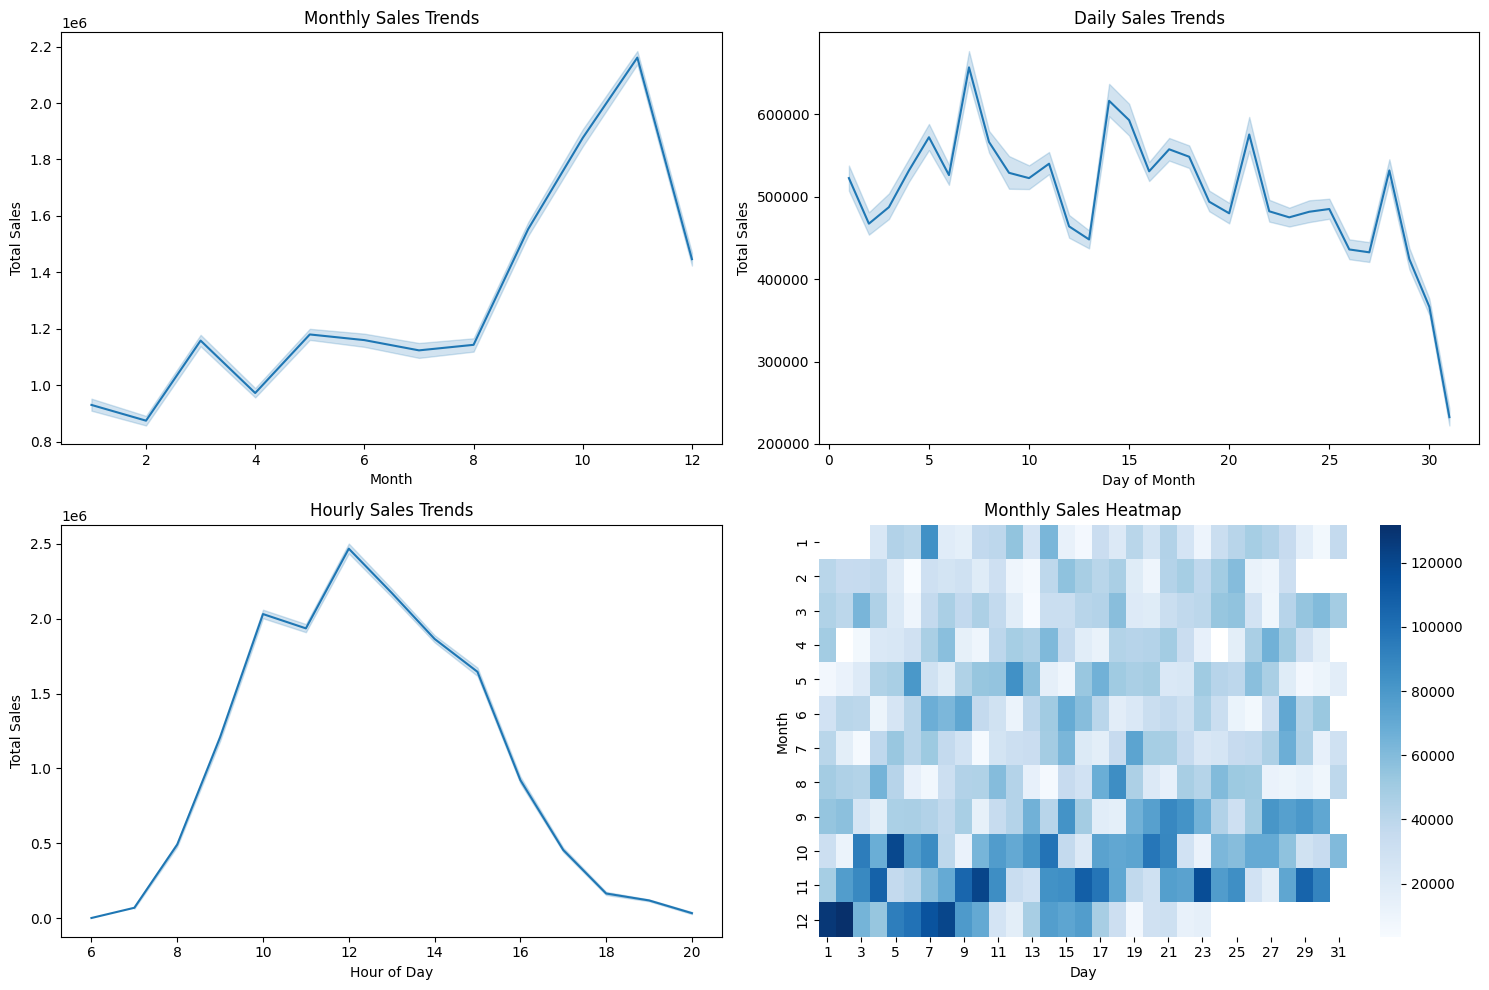

In [ ]:
# Set up subplots for time-based analysis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Monthly sales trends
sns.lineplot(x='Month', y='Amount', data=df, estimator='sum', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Sales Trends')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Sales')

# Daily sales trends
sns.lineplot(x='Day', y='Amount', data=df, estimator='sum', ax=axes[0, 1])
axes[0, 1].set_title('Daily Sales Trends')
axes[0, 1].set_xlabel('Day of Month')
axes[0, 1].set_ylabel('Total Sales')

# Hourly sales trends
sns.lineplot(x='Hour', y='Amount', data=df, estimator='sum', ax=axes[1, 0])
axes[1, 0].set_title('Hourly Sales Trends')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Sales')

# Monthly sales heatmap
monthly_sales_heatmap = df.groupby(['Month', 'Day'])['Amount'].sum().unstack()
sns.heatmap(monthly_sales_heatmap, cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Sales Heatmap')

plt.tight_layout()
plt.show()

* We can observe that there is a increased sale of goods in the last 5 months (more of the later half of the year)<br>
* The daily sales trend kind of stays constant, but declines towards the end of a month
* The hourly sale sees a spike in the middle of the day, and decreases in the very early and late hours
* The heatmap shows that the sale of goods is more during the last 3 months in contrast to the initial months of the year

#### 8. Correlation Analysis

In [ ]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(df['Quantity'], df['Price'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
# Interpretation
if correlation_coefficient > 0:
    print("There is a positive correlation between Quantity and Price.")
elif correlation_coefficient < 0:
    print("There is a negative correlation between Quantity and Price.")
else:
    print("There is no correlation between Quantity and Price.")

Pearson Correlation Coefficient: -0.19047973245926025
There is a negative correlation between Quantity and Price.


This makes sense as well, because as the price of a product increases consumers tend to buy lower quantities of the product.

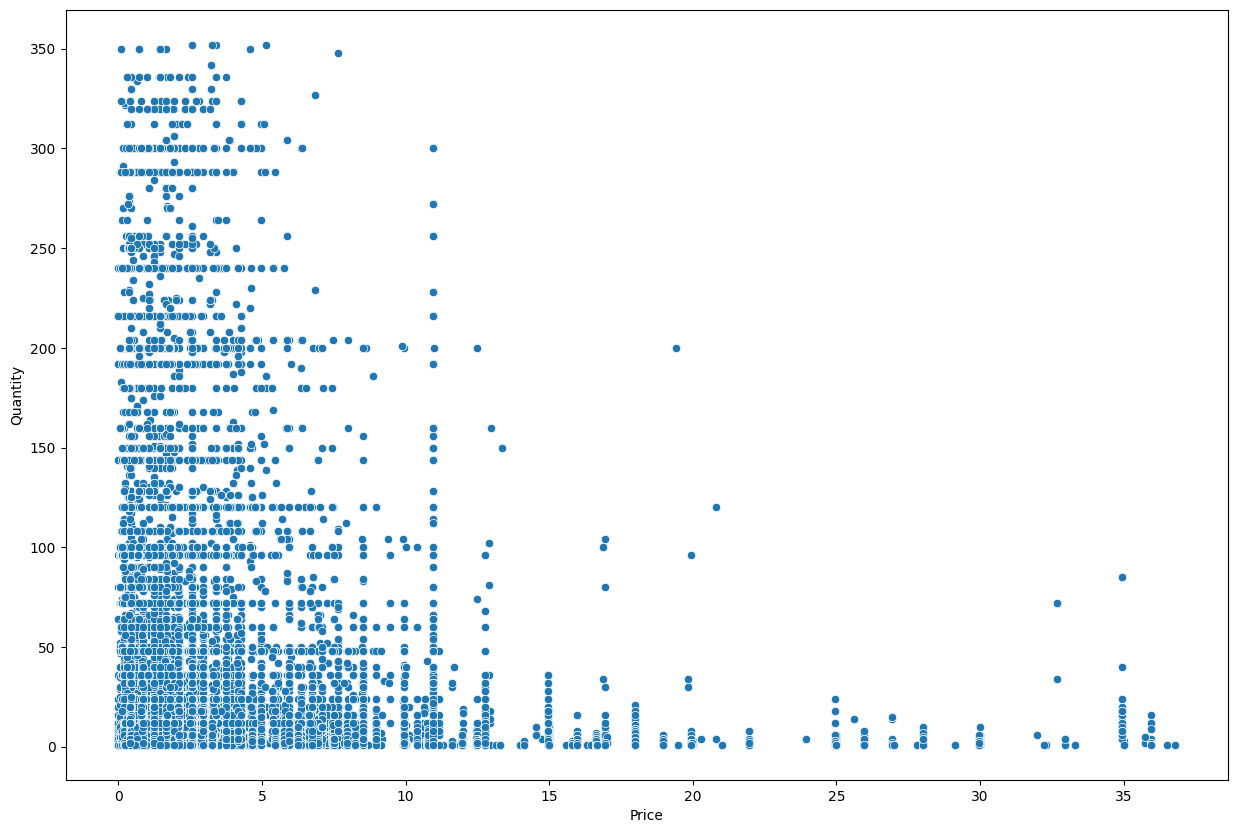

In [ ]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = df, x = df['Price'], y = df['Quantity'])
plt.show()

In [ ]:
print('Correlation matrix :')
df.corr()

Correlation matrix :


Quantity     Price  Customer ID    Amount     Month       Day  \
Quantity     1.000000 -0.190480    -0.054536  0.640127 -0.019210 -0.005967   
Price       -0.190480  1.000000    -0.026243  0.133775 -0.020899 -0.001568   
Customer ID -0.054536 -0.026243     1.000000 -0.037775  0.028848  0.000497   
Amount       0.640127  0.133775    -0.037775  1.000000 -0.014668 -0.006945   
Month       -0.019210 -0.020899     0.028848 -0.014668  1.000000 -0.115357   
Day         -0.005967 -0.001568     0.000497 -0.006945 -0.115357  1.000000   
Hour        -0.078898 -0.011526     0.065437 -0.065528  0.048030  0.003809   

                 Hour  
Quantity    -0.078898  
Price       -0.011526  
Customer ID  0.065437  
Amount      -0.065528  
Month        0.048030  
Day          0.003809  
Hour         1.000000

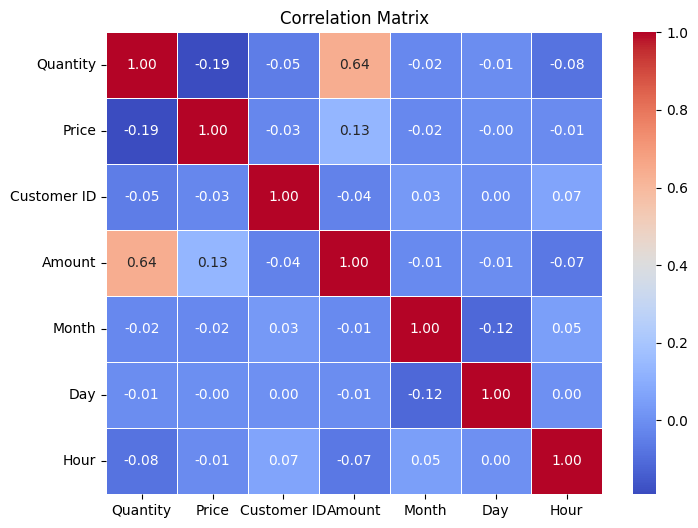

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

There doesn't seem to be any correlation majorly between any variables. There is significant correaltion between Quantity and Amount because Amount was derived using Quantity and Price.

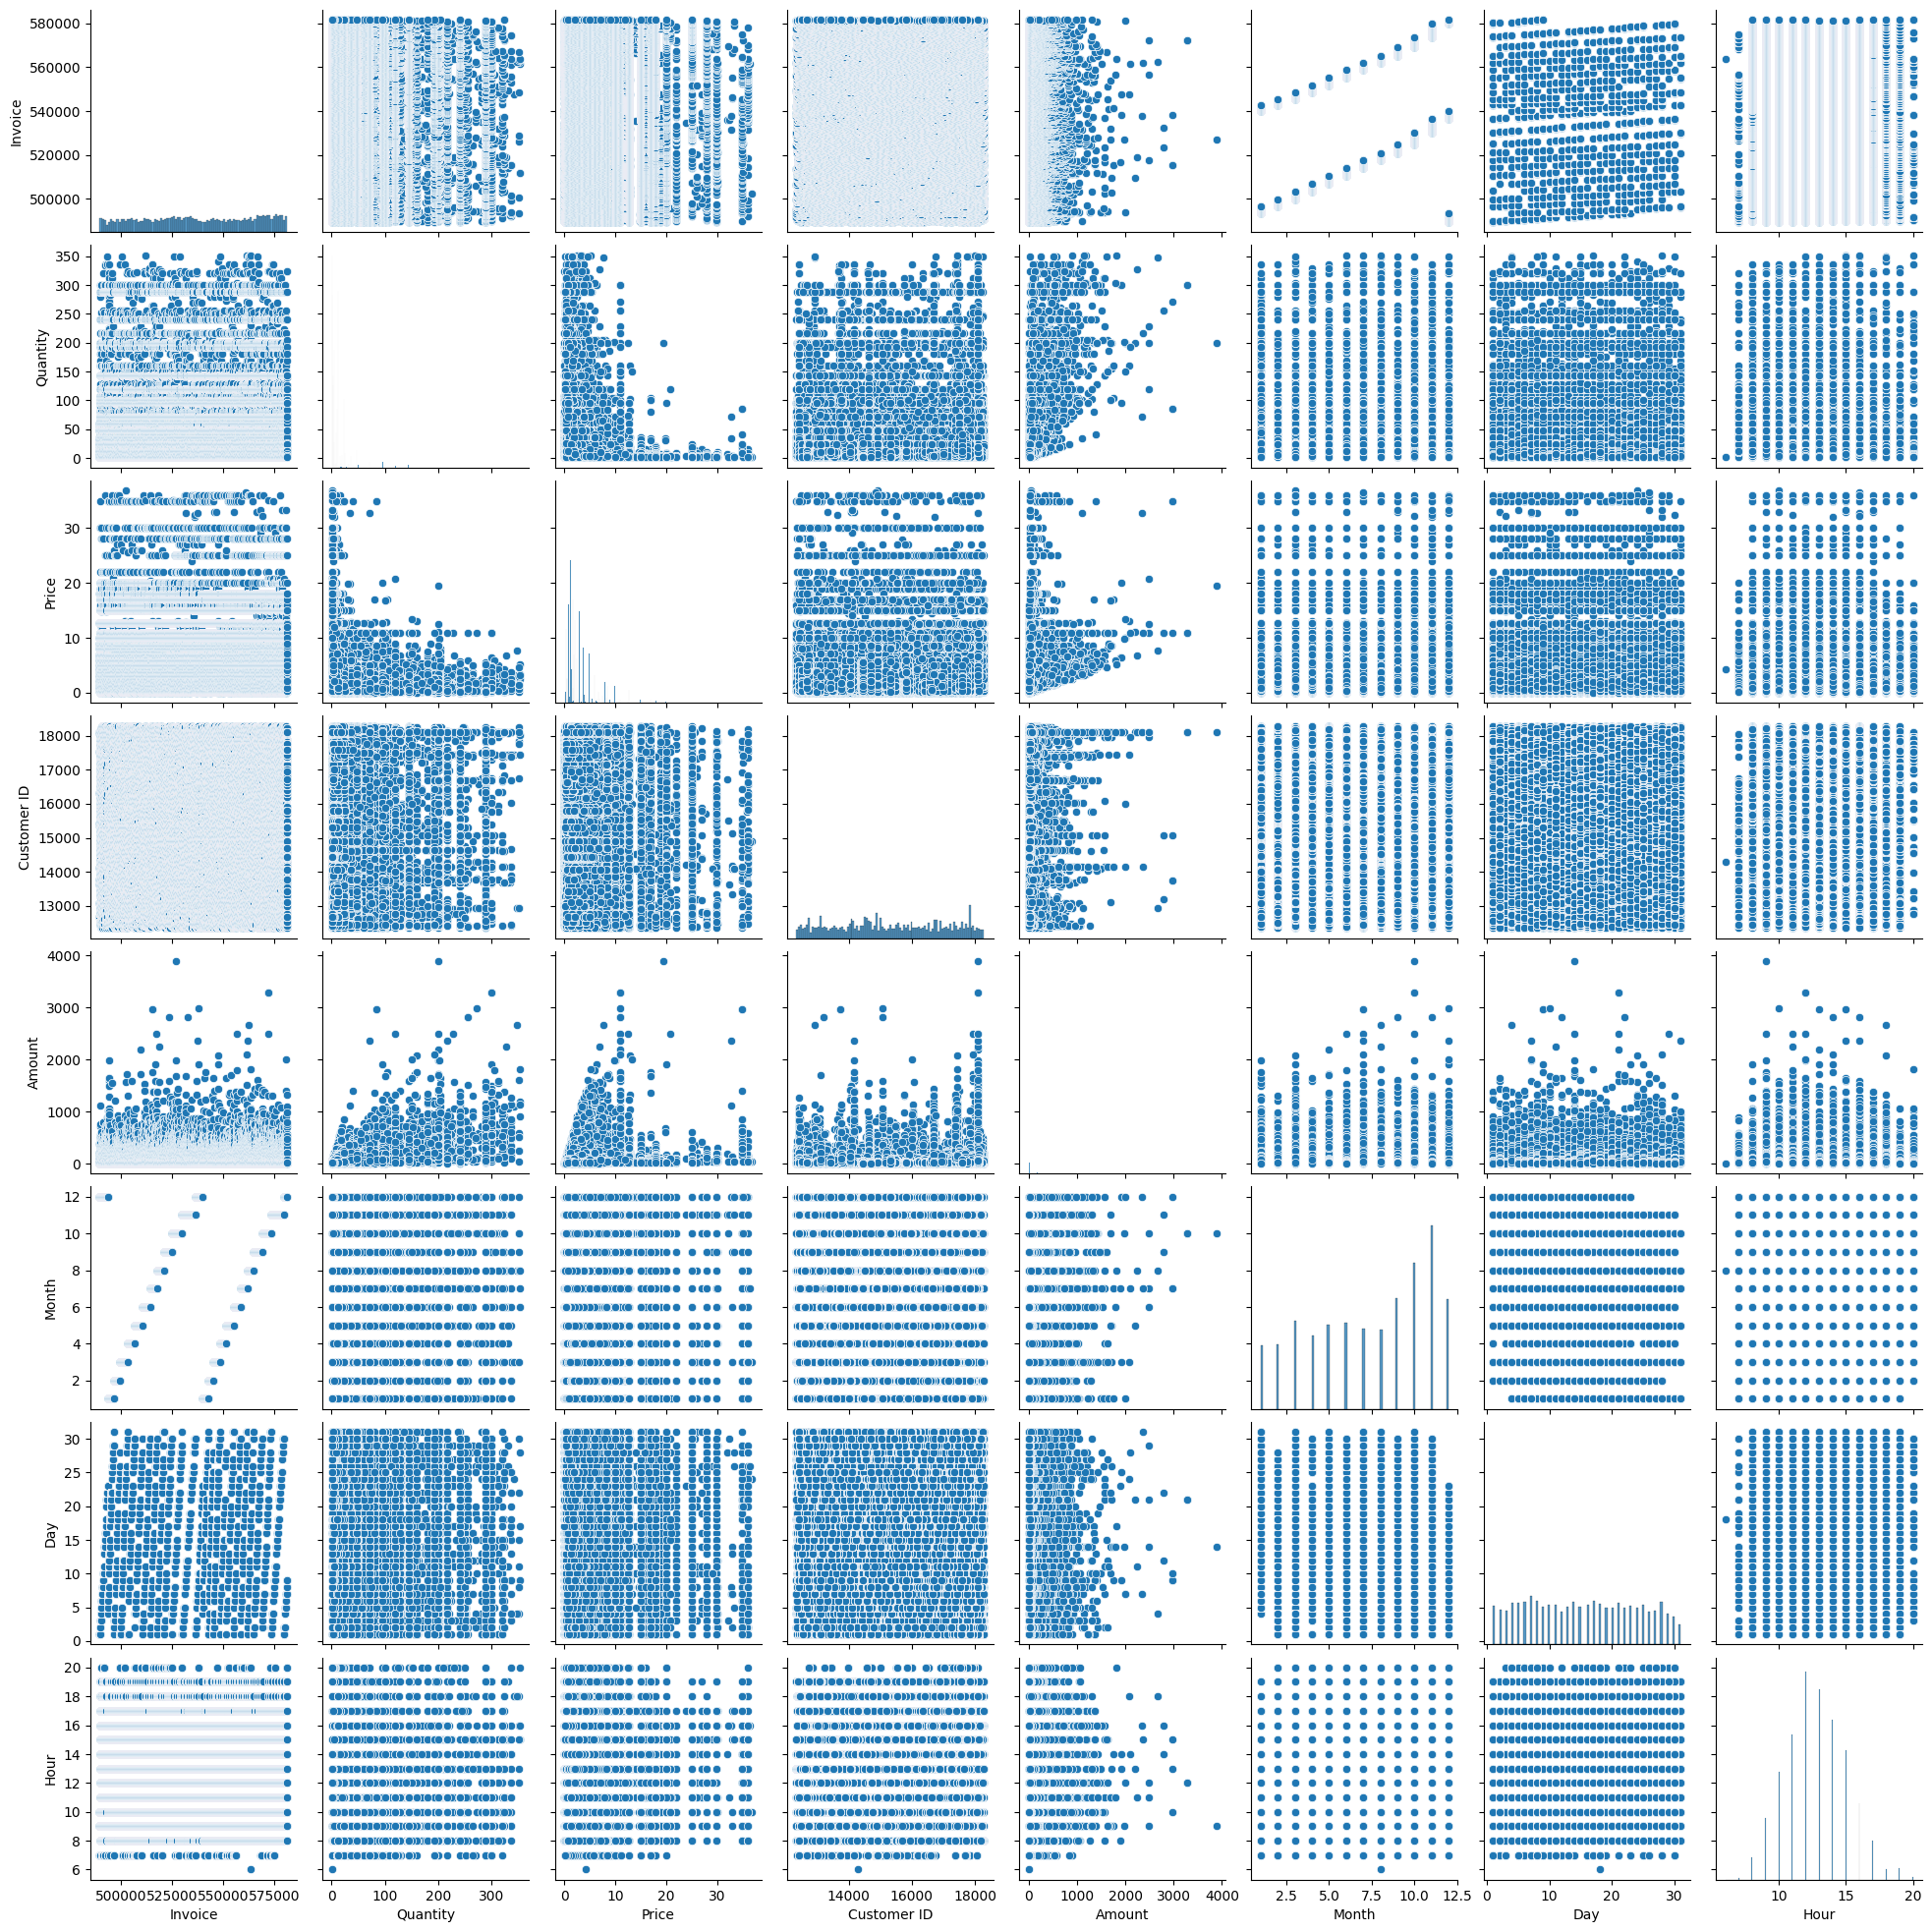

In [ ]:
sns.pairplot(df)

### 9. Market Basket Analysis

#### 9a. Start with Apriori Algorithm to get the association mining rules

The Apriori algorithm is commonly used for association rule mining. Before applying the Apriori algorithm, we need to format your data in a way that each row represents a transaction and each column represents an item

In [ ]:
# Drop duplicate rows to ensure that the same product is not counted multiple times in a single transaction
df_unique = df[['Customer ID', 'Description']].drop_duplicates()
# Create a one-hot encoded matrix
basket = df_unique.pivot_table(index='Customer ID', columns='Description', aggfunc='size', fill_value=0)
basket

Description  10 COLOUR SPACEBOY PEN  11 PC CERAMIC TEA SET POLKADOT  \
Customer ID                                                           
12346.0                           0                               0   
12347.0                           1                               0   
12348.0                           0                               0   
12349.0                           0                               0   
12350.0                           0                               0   
...                             ...                             ...   
18283.0                           1                               0   
18284.0                           1                               0   
18285.0                           0                               0   
18286.0                           1                               0   
18287.0                           0                               0   

Description  12 ASS ZINC CHRISTMAS DECORATIONS  12 COLOURED PARTY BALLOONS  \
Customer ID                                                                  
12346.0                                      0                           0   
12347.0                                      0                           0   
12348.0                                      0                           0   
12349.0                                      0                           0   
12350.0                                      0                           0   
...                                        ...                         ...   
18283.0                                      0                           0   
18284.0                                      0                           0   
18285.0                                      0                           0   
18286.0                                      0                           0   
18287.0                                      0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
Customer ID                                                         
12346.0                              0                          0   
12347.0                              0                          0   
12348.0                              0                          0   
12349.0                              0                          0   
12350.0                              0                          0   
...                                ...                        ...   
18283.0                              0                          0   
18284.0                              0                          0   
18285.0                              0                          0   
18286.0                              0                          0   
18287.0                              0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
Customer ID                                                                   
12346.0                                 0                                 0   
12347.0                                 0                                 0   
12348.0                                 0                                 0   
12349.0                                 0                                 0   
12350.0                                 0                                 0   
...                                   ...                               ...   
18283.0                                 0                                 0   
18284.0                                 0                                 0   
18285.0                                 0                                 0   
18286.0                                 0                                 0   
18287.0                                 0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 MINI TOADSTOOL PEGS  ...  \
Customer ID                                               

In [ ]:
# Convert counts to binary values (0 or 1)
basket[basket > 0] = 1
basket.head()

Description  10 COLOUR SPACEBOY PEN  11 PC CERAMIC TEA SET POLKADOT  \
Customer ID                                                           
12346.0                           0                               0   
12347.0                           1                               0   
12348.0                           0                               0   
12349.0                           0                               0   
12350.0                           0                               0   

Description  12 ASS ZINC CHRISTMAS DECORATIONS  12 COLOURED PARTY BALLOONS  \
Customer ID                                                                  
12346.0                                      0                           0   
12347.0                                      0                           0   
12348.0                                      0                           0   
12349.0                                      0                           0   
12350.0                                      0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
Customer ID                                                         
12346.0                              0                          0   
12347.0                              0                          0   
12348.0                              0                          0   
12349.0                              0                          0   
12350.0                              0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
Customer ID                                                                   
12346.0                                 0                                 0   
12347.0                                 0                                 0   
12348.0                                 0                                 0   
12349.0                                 0                                 0   
12350.0                                 0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 MINI TOADSTOOL PEGS  ...  \
Customer ID                                                           ...   
12346.0                                    0                       0  ...   
12347.0                                    0                       0  ...   
12348.0                                    0                       0  ...   
12349.0                                    0                       0  ...   
12350.0                                    0                       0  ...   

Description  ZINC STAR T-LIGHT HOLDER  ZINC SWEETHEART SOAP DISH  \
Customer ID                                                        
12346.0                             0                          0   
12347.0                             0                          0   
12348.0                             0                          0   
12349.0                             0                          0   
12350.0                             0                          0   

Description  ZINC SWEETHEART WIRE LETTER RACK  ZINC T-LIGHT HOLDER STAR LARGE  \
Customer ID                                                                     
12346.0                                     0                               0   
12347.0                                     0                               0   
12348.0                                     0                               0   
12349.0                                     0                               0   
12350.0                                     0                               0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
Customer ID                                                                     
12346.0                                    0                                0   
12347.0                                    0                                0   
12348.0 

In [ ]:
basket.describe()

Description  10 COLOUR SPACEBOY PEN  11 PC CERAMIC TEA SET POLKADOT  \
count                   5833.000000                     5833.000000   
mean                       0.056575                        0.000171   
std                        0.231048                        0.013093   
min                        0.000000                        0.000000   
25%                        0.000000                        0.000000   
50%                        0.000000                        0.000000   
75%                        0.000000                        0.000000   
max                        1.000000                        1.000000   

Description  12 ASS ZINC CHRISTMAS DECORATIONS  12 COLOURED PARTY BALLOONS  \
count                              5833.000000                 5833.000000   
mean                                  0.006686                    0.029659   
std                                   0.081502                    0.169659   
min                                   0.000000                    0.000000   
25%                                   0.000000                    0.000000   
50%                                   0.000000                    0.000000   
75%                                   0.000000                    0.000000   
max                                   1.000000                    1.000000   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
count                      5833.000000                5833.000000   
mean                          0.022630                   0.015772   
std                           0.148733                   0.124604   
min                           0.000000                   0.000000   
25%                           0.000000                   0.000000   
50%                           0.000000                   0.000000   
75%                           0.000000                   0.000000   
max                           1.000000                   1.000000   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
count                         5833.000000                       5833.000000   
mean                             0.001200                          0.025544   
std                              0.034624                          0.157785   
min                              0.000000                          0.000000   
25%                              0.000000                          0.000000   
50%                              0.000000                          0.000000   
75%                              0.000000                          0.000000   
max                              1.000000                          1.000000   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 MINI TOADSTOOL PEGS  ...  \
count                            5833.000000             5833.000000  ...   
mean                                0.046974                0.012344  ...   
std                                 0.211602                0.110423  ...   
min                                 0.000000                0.000000  ...   
25%                                 0.000000                0.000000  ...   
50%                                 0.000000                0.000000  ...   
75%                                 0.000000                0.000000  ...   
max                                 1.000000                1.000000  ...   

Description  ZINC STAR T-LIGHT HOLDER  ZINC SWEETHEART SOAP DISH  \
count                     5833.000000                5833.000000   
mean                         0.000171                   0.003086   
std                          0.013093                   0.055470   
min                          0.000000                   0.000000   
25%                          0.000000                   0.000000   
50%                          0.000000                   0.000000   
75%                          0.000000                   0.000000   
max                          1.000000                   1.000000   

Description  ZIN

In [ ]:
# Record start time
start_time = time.time()
# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)
end_time = time.time()
# Calculate execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")
# Display the frequent itemsets
print("Frequent Itemsets:")
frequent_itemsets

Execution Time: 7.038375616073608 seconds
Frequent Itemsets:


support                                           itemsets
0    0.056575                           (10 COLOUR SPACEBOY PEN)
1    0.052289                    (12 PENCIL SMALL TUBE WOODLAND)
2    0.054175              (12 PENCILS SMALL TUBE RED RETROSPOT)
3    0.063089                      (12 PENCILS SMALL TUBE SKULL)
4    0.054003                      (12 PENCILS TALL TUBE SKULLS)
..        ...                                                ...
553  0.050403  (LUNCH BAG WOODLAND, LUNCH BAG SPACEBOY DESIGN...
554  0.050746  (LUNCH BAG CARS BLUE, LUNCH BAG RED RETROSPOT,...
555  0.052289  (LUNCH BAG CARS BLUE, LUNCH BAG WOODLAND, LUNC...
556  0.050917  (REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...
557  0.050746  (WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FR...

[558 rows x 2 columns]

In [ ]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
# Display the association rules
print("\nAssociation Rules:")
rules


Association Rules:


antecedents  \
0                           (3 STRIPEY MICE FELTCRAFT)   
1                         (FELTCRAFT 6 FLOWER FRIENDS)   
2                        (60 TEATIME FAIRY CAKE CASES)   
3                     (72 SWEETHEART FAIRY CAKE CASES)   
4                       (BAKING SET 9 PIECE RETROSPOT)   
..                                                 ...   
371  (WOODEN FRAME ANTIQUE WHITE, WHITE HANGING HEA...   
372  (WOODEN PICTURE FRAME WHITE FINISH, WHITE HANG...   
373                       (WOODEN FRAME ANTIQUE WHITE)   
374                (WOODEN PICTURE FRAME WHITE FINISH)   
375               (WHITE HANGING HEART T-LIGHT HOLDER)   

                                           consequents  antecedent support  \
0                         (FELTCRAFT 6 FLOWER FRIENDS)            0.086576   
1                           (3 STRIPEY MICE FELTCRAFT)            0.116921   
2                     (72 SWEETHEART FAIRY CAKE CASES)            0.140237   
3                        (60 TEATIME FAIRY CAKE CASES)            0.104920   
4                        (60 TEATIME FAIRY CAKE CASES)            0.194411   
..                                                 ...                 ...   
371                (WOODEN PICTURE FRAME WHITE FINISH)            0.064289   
372                       (WOODEN FRAME ANTIQUE WHITE)            0.064118   
373  (WOODEN PICTURE FRAME WHITE FINISH, WHITE HANG...            0.107835   
374  (WOODEN FRAME ANTIQUE WHITE, WHITE HANGING HEA...            0.102863   
375  (WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FR...            0.255100   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.116921  0.050231    0.580198  4.962309  0.040109    2.103561   
1              0.086576  0.050231    0.429619  4.962309  0.040109    1.601427   
2              0.104920  0.065832    0.469438  4.474232  0.051119    1.687040   
3              0.140237  0.065832    0.627451  4.474232  0.051119    2.307786   
4              0.140237  0.050231    0.258377  1.842440  0.022968    1.159300   
..                  ...       ...         ...       ...       ...         ...   
371            0.102863  0.050746    0.789333  7.673636  0.044133    4.258562   
372            0.107835  0.050746    0.791444  7.339415  0.043832    4.277818   
373            0.064118  0.050746    0.470588  7.339415  0.043832    1.767777   
374            0.064289  0.050746    0.493333  7.673636  0.044133    1.846797   
375            0.075604  0.050746    0.198925  2.631129  0.031459    1.153944   

     zhangs_metric  
0         0.874163  
1         0.904201  
2         0.903153  
3         0.867518  
4         0.567586  
..             ...  
371       0.929437  
372       0.922925  
373       0.968150  
374       0.969399  
375       0.832240  

[376 rows x 10 columns]

#### 9b. Use FP Growth algorithm

* It is memory-efficient
* Better for sparse dataset
* Faster than apriori for large datasets

In [ ]:
frequent_itemsets_fp = fpgrowth(basket, min_support=0.05, use_colnames=True)
# Display the frequent itemsets with FP-growth
print("Frequent Itemsets with FP-growth:")
frequent_itemsets_fp

Frequent Itemsets with FP-growth:


support                                           itemsets
0    0.079719                               (DOORMAT UNION FLAG)
1    0.066347                              (DOORMAT NEW ENGLAND)
2    0.060689                   (DOORMAT SPOTTY HOME SWEET HOME)
3    0.059318                        (EDWARDIAN PARASOL NATURAL)
4    0.054860                          (EDWARDIAN PARASOL BLACK)
..        ...                                                ...
553  0.050060  (HEART OF WICKER SMALL, ZINC METAL HEART DECOR...
554  0.064289  (WOODEN FRAME ANTIQUE WHITE, WHITE HANGING HEA...
555  0.050574               (HEART OF WICKER SMALL, WICKER STAR)
556  0.058118               (HEART OF WICKER LARGE, WICKER STAR)
557  0.061718  (WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN S...

[558 rows x 2 columns]

In [ ]:
rules = association_rules(frequent_itemsets_fp,metric = "confidence",min_threshold = 0.05)
rules.head(100)

antecedents  \
0             (REGENCY CAKESTAND 3 TIER)   
1   (WHITE HANGING HEART T-LIGHT HOLDER)   
2             (REGENCY CAKESTAND 3 TIER)   
3          (60 TEATIME FAIRY CAKE CASES)   
4         (BAKING SET 9 PIECE RETROSPOT)   
..                                   ...   
95      (NATURAL SLATE HEART CHALKBOARD)   
96     (RECIPE BOX PANTRY YELLOW DESIGN)   
97  (WHITE HANGING HEART T-LIGHT HOLDER)   
98      (STRAWBERRY CERAMIC TRINKET BOX)   
99  (WHITE HANGING HEART T-LIGHT HOLDER)   

                             consequents  antecedent support  \
0   (WHITE HANGING HEART T-LIGHT HOLDER)            0.225270   
1             (REGENCY CAKESTAND 3 TIER)            0.255100   
2          (60 TEATIME FAIRY CAKE CASES)            0.225270   
3             (REGENCY CAKESTAND 3 TIER)            0.140237   
4          (60 TEATIME FAIRY CAKE CASES)            0.194411   
..                                   ...                 ...   
95               (HEART OF WICKER SMALL)            0.149666   
96  (WHITE HANGING HEART T-LIGHT HOLDER)            0.119321   
97     (RECIPE BOX PANTRY YELLOW DESIGN)            0.255100   
98  (WHITE HANGING HEART T-LIGHT HOLDER)            0.116921   
99      (STRAWBERRY CERAMIC TRINKET BOX)            0.255100   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.255100  0.083490    0.370624  1.452856  0.026024    1.183553   
1             0.225270  0.083490    0.327285  1.452856  0.026024    1.151647   
2             0.140237  0.055032    0.244292  1.742001  0.023441    1.137693   
3             0.225270  0.055032    0.392421  1.742001  0.023441    1.275109   
4             0.140237  0.050231    0.258377  1.842440  0.022968    1.159300   
..                 ...       ...         ...       ...       ...         ...   
95            0.151723  0.059832    0.399771  2.634874  0.037124    1.413255   
96            0.255100  0.051089    0.428161  1.678402  0.020650    1.302639   
97            0.119321  0.051089    0.200269  1.678402  0.020650    1.101219   
98            0.255100  0.057089    0.488270  1.914031  0.027262    1.455649   
99            0.116921  0.057089    0.223790  1.914031  0.027262    1.137681   

    zhangs_metric  
0        0.402335  
1        0.418446  
2        0.549801  
3        0.495424  
4        0.567586  
..            ...  
95       0.729684  
96       0.458959  
97       0.542617  
98       0.540770  
99       0.641083  

[100 rows x 10 columns]

In [ ]:
rules[(rules['lift'] >= 3) & (rules['confidence'] >= 0.5)]

antecedents  \
8                     (VINTAGE SNAP CARDS)   
9      (VINTAGE HEADS AND TAILS CARD GAME)   
11        (72 SWEETHEART FAIRY CAKE CASES)   
13        (72 SWEETHEART FAIRY CAKE CASES)   
15        (72 SWEETHEART FAIRY CAKE CASES)   
..                                     ...   
363                  (BATHROOM METAL SIGN)   
371                          (WICKER STAR)   
373                          (WICKER STAR)   
374  (WOODEN HEART CHRISTMAS SCANDINAVIAN)   
375   (WOODEN STAR CHRISTMAS SCANDINAVIAN)   

                               consequents  antecedent support  \
8      (VINTAGE HEADS AND TAILS CARD GAME)            0.135608   
9                     (VINTAGE SNAP CARDS)            0.109721   
11           (60 TEATIME FAIRY CAKE CASES)            0.104920   
13    (PACK OF 60 PINK PAISLEY CAKE CASES)            0.104920   
15       (PACK OF 72 RETROSPOT CAKE CASES)            0.104920   
..                                     ...                 ...   
363                    (TOILET METAL SIGN)            0.085548   
371                (HEART OF WICKER SMALL)            0.082805   
373                (HEART OF WICKER LARGE)            0.082805   
374   (WOODEN STAR CHRISTMAS SCANDINAVIAN)            0.088462   
375  (WOODEN HEART CHRISTMAS SCANDINAVIAN)            0.082633   

     consequent support   support  confidence       lift  leverage  \
8              0.109721  0.074919    0.552465   5.035203  0.060040   
9              0.135608  0.074919    0.682813   5.035203  0.060040   
11             0.140237  0.065832    0.627451   4.474232  0.051119   
13             0.131150  0.060175    0.573529   4.373068  0.046415   
15             0.131836  0.053146    0.506536   3.842164  0.039314   
..                  ...       ...         ...        ...       ...   
363            0.063604  0.054517    0.637275  10.019468  0.049076   
371            0.151723  0.050574    0.610766   4.025535  0.038011   
373            0.141265  0.058118    0.701863   4.968409  0.046420   
374            0.082633  0.061718    0.697674   8.443018  0.054408   
375            0.088462  0.061718    0.746888   8.443018  0.054408   

     conviction  zhangs_metric  
8      1.989297       0.927123  
9      2.725178       0.900165  
11     2.307786       0.867518  
13     2.037303       0.861742  
15     1.759326       0.826440  
..          ...            ...  
363    2.581557       0.984408  
371    2.179350       0.819439  
373    2.880340       0.870838  
374    3.034367       0.967112  
375    3.601321       0.960967  

[186 rows x 10 columns]

#### Let's try it out with a input

In [ ]:
unique_values = df_unique['Description'].unique()
print(f"There are totally {len(unique_values)} items in our store, what do you want to pick :")

user_input = input("Enter the name of the item you want to pick: ")
user_input = user_input.strip()

filtered = rules[rules["antecedents"] == frozenset({user_input})]["consequents"]
filtered.size
if filtered.size == 0:
    print("There are no recommended items for this product, choose a different item")
else:
    print("Here are your recommended items for  "+user_input+"--")
    print(filtered)
    items = []
    for data in filtered:
        items.extend(data)

There are totally 5220 items in our store, what do you want to pick :
Enter the name of the item you want to pick: ROSES REGENCY TEACUP AND SAUCER
Here are your recommended items for  ROSES REGENCY TEACUP AND SAUCER--
25                           (REGENCY CAKESTAND 3 TIER)
34                    (GREEN REGENCY TEACUP AND SAUCER)
42    (REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...
48                     (PINK REGENCY TEACUP AND SAUCER)
55    (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...
68    (REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP...
Name: consequents, dtype: object


In [ ]:
item=input("What is the item you want to pick")
filtered = rules[rules["antecedents"] == frozenset({item})]["consequents"]
filtered.size
if filtered.size == 0:
    print("There are no recommended items for this product, choose a different item")
else:
    print("Here are your recommended items for  "+item+"--")
    print(filtered)
    items = []
    for data in filtered:
        items.extend(data)

What is the item you want to pickROSES REGENCY TEACUP AND SAUCER
Here are your recommended items for  ROSES REGENCY TEACUP AND SAUCER--
25                           (REGENCY CAKESTAND 3 TIER)
34                    (GREEN REGENCY TEACUP AND SAUCER)
42    (REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...
48                     (PINK REGENCY TEACUP AND SAUCER)
55    (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...
68    (REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP...
Name: consequents, dtype: object


### 9c. RFM analysis to calculate Recency, Frequency, and Monetary and use these further for Customer Segementation

Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

In [ ]:
# Calculating RFM metrics
current_date = max(df['InvoiceDate'])  # Current date

# Calculate Recency, Frequency, and Monetary metrics for each customer
rfm_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'Amount': 'sum'  # Monetary value
})

# Rename columns
rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)

# Print the first few rows of the RFM DataFrame
rfm_df = rfm_df.sort_values(by = 'Monetary',ascending = False)
rfm_df.head()

Recency  Frequency   Monetary
Customer ID                               
14646.0            1        146  479320.00
18102.0            0        134  429970.66
14156.0            9        146  279145.20
14911.0            0        376  269686.47
13694.0            3        134  182438.31

We are sorting them in descening order of Monetary value as the Monetary aspect is a crucial component of RFM analysis as it helps segment customers based on their purchasing behavior and contribution to revenue. Customers who spend more tend to be more valuable to a business, and identifying these high-value customers can assist in targeted marketing strategies, loyalty programs, and personalized offerings to maximize revenue and customer retention.

#### Customer Segmentation based on RFM values

In [ ]:
def create_segments(row):
    if row['Recency'] <= 30 and row['Frequency'] >= 100 and row['Monetary'] >= 50000:
        return 'High-Value Customer'
    elif row['Recency'] > 90 and row['Frequency'] < 3:
        return 'Churn Risk'
    else:
        return 'Regular Customer'

rfm_df['Segment'] = rfm_df.apply(create_segments, axis=1)

print("RFM Analysis with Segments:")
rfm_df.head(20)

RFM Analysis with Segments:


Recency  Frequency   Monetary              Segment
Customer ID                                                    
14646.0            1        146  479320.00  High-Value Customer
18102.0            0        134  429970.66  High-Value Customer
14156.0            9        146  279145.20  High-Value Customer
14911.0            0        376  269686.47  High-Value Customer
13694.0            3        134  182438.31  High-Value Customer
17511.0            2         60  171344.92     Regular Customer
12415.0           23         26  134463.45     Regular Customer
16684.0            3         49  119972.57     Regular Customer
15061.0            3        123  117693.94  High-Value Customer
15311.0            0        208  114369.88  High-Value Customer
13089.0            2        202  113115.06  High-Value Customer
17450.0            7         44   90449.63     Regular Customer
14298.0            7         79   89680.15     Regular Customer
16029.0           38        103   78038.63     Regular Customer
13798.0            0        110   75260.39  High-Value Customer
17841.0            1        211   67019.32  High-Value Customer
15769.0            6         44   65333.52     Regular Customer
14088.0            9         16   63480.75     Regular Customer
17389.0            0         61   57215.33     Regular Customer
13081.0           11         28   56653.69     Regular Customer

This was one way to do this. Now we will be trying another method where we convert these values to the range from 1 to 5 across all the metrics for easier segmentation and for having a consistent range across all the metrics

Customers with the highest RFM score is considered the "best" customer. They have made recent purchases (high R), engage frequently (high F), and contribute significantly in terms of monetary value (high M). These customers are often considered the most valuable and important for the business.

In [ ]:
r_labels, f_labels, m_labels = range(1, 6), range(1,6), range(1,6)
# Define custom bins (adjust according to your data distribution)
custom_bins = [0, 5, 10, 20, 30, 1000]

# Use pd.cut() with custom bins
rfm_df['r_score'] = pd.qcut(rfm_df['Recency'], q=5, labels=r_labels).astype(int)
rfm_df['f_score'] = pd.cut(rfm_df['Frequency'], bins=custom_bins, labels=f_labels).astype(int)
rfm_df['m_score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=m_labels).astype(int)

rfm_df['rfm_sum'] = rfm_df['r_score'] + rfm_df['m_score'] + rfm_df['f_score']
rfm_df = rfm_df.sort_values(by = "rfm_sum",ascending = False)
rfm_df

Recency  Frequency  Monetary           Segment  r_score  f_score  \
Customer ID                                                                     
17448.0          496         46  14498.47  Regular Customer        5        5   
12835.0          427         41   5982.53  Regular Customer        5        5   
17850.0          371        155  51080.65  Regular Customer        4        5   
12482.0          575         27  20807.00  Regular Customer        5        4   
13564.0          353         36  15798.83  Regular Customer        4        5   
...              ...        ...       ...               ...      ...      ...   
14349.0            9          1    133.50  Regular Customer        1        1   
18005.0            3          2    226.47  Regular Customer        1        1   
16528.0            3          1    244.41  Regular Customer        1        1   
12660.0           10          1    245.10  Regular Customer        1        1   
16189.0           15          2    215.48  Regular Customer        1        1   

             m_score  rfm_sum  
Customer ID                    
17448.0            5       15  
12835.0            5       15  
17850.0            5       14  
12482.0            5       14  
13564.0            5       14  
...              ...      ...  
14349.0            1        3  
18005.0            1        3  
16528.0            1        3  
12660.0            1        3  
16189.0            1        3  

[5833 rows x 8 columns]

We will be assigning labels to the customers based on their transaction history

In [ ]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [ ]:
rfm_df['rfm_label'] = ''

rfm_df = assign_label(rfm_df, (5,5), (4,5), 'champions')
rfm_df = assign_label(rfm_df, (3,4), (4,5), 'loyal customers')
rfm_df = assign_label(rfm_df, (4,5), (2,3), 'potential loyalist')
rfm_df = assign_label(rfm_df, (5,5), (1,1), 'new customers')
rfm_df = assign_label(rfm_df, (4,4), (1,1), 'promising')
rfm_df = assign_label(rfm_df, (3,3), (3,3), 'needing attention')
rfm_df = assign_label(rfm_df, (3,3), (1,2), 'about to sleep')
rfm_df = assign_label(rfm_df, (1,2), (3,4), 'at risk')
rfm_df = assign_label(rfm_df, (1,2), (5,5), 'cant loose them')
rfm_df = assign_label(rfm_df, (1,2), (1,2), 'hibernating')
rfm_df

Recency  Frequency  Monetary           Segment  r_score  f_score  \
Customer ID                                                                     
17448.0          496         46  14498.47  Regular Customer        5        5   
12835.0          427         41   5982.53  Regular Customer        5        5   
17850.0          371        155  51080.65  Regular Customer        4        5   
12482.0          575         27  20807.00  Regular Customer        5        4   
13564.0          353         36  15798.83  Regular Customer        4        5   
...              ...        ...       ...               ...      ...      ...   
14349.0            9          1    133.50  Regular Customer        1        1   
18005.0            3          2    226.47  Regular Customer        1        1   
16528.0            3          1    244.41  Regular Customer        1        1   
12660.0           10          1    245.10  Regular Customer        1        1   
16189.0           15          2    215.48  Regular Customer        1        1   

             m_score  rfm_sum        rfm_label  
Customer ID                                     
17448.0            5       15        champions  
12835.0            5       15        champions  
17850.0            5       14  loyal customers  
12482.0            5       14        champions  
13564.0            5       14  loyal customers  
...              ...      ...              ...  
14349.0            1        3      hibernating  
18005.0            1        3      hibernating  
16528.0            1        3      hibernating  
12660.0            1        3      hibernating  
16189.0            1        3      hibernating  

[5833 rows x 9 columns]

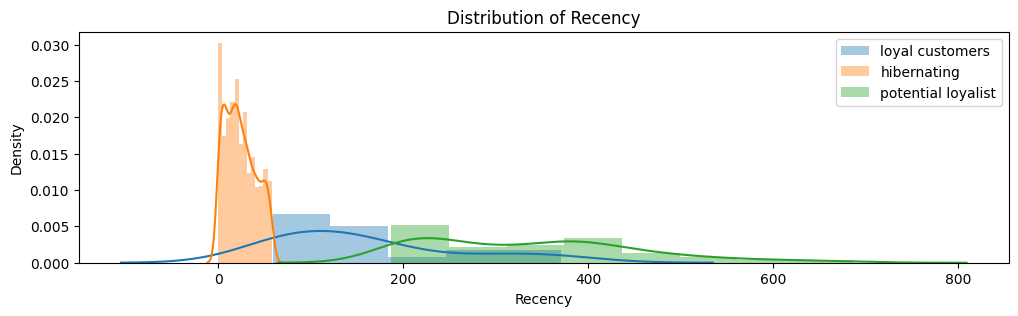

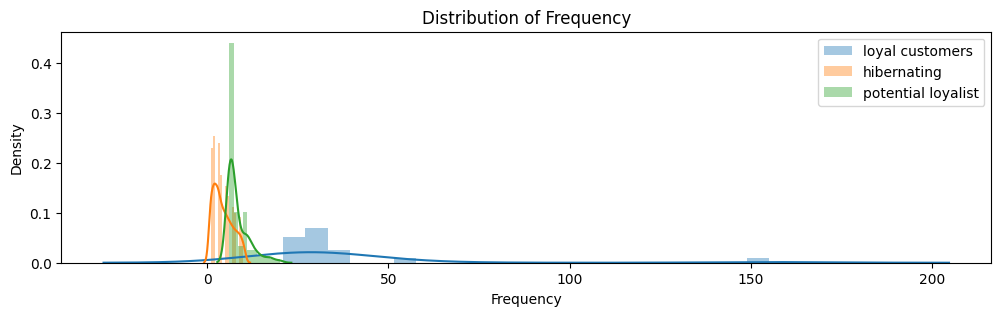

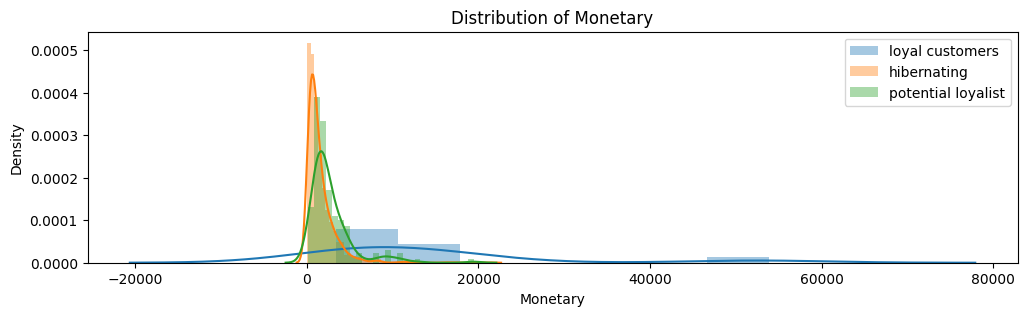

In [ ]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in ['Recency','Frequency','Monetary']:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(rfm_df[rfm_df['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

## K means clustering for customer segmentation



In [ ]:
cluster_df = pd.DataFrame()
for i in ['Recency','Frequency','Monetary']:
    cluster_df[i] = rfm_df[i]
cluster_df

Recency  Frequency  Monetary
Customer ID                              
17448.0          496         46  14498.47
12835.0          427         41   5982.53
17850.0          371        155  51080.65
12482.0          575         27  20807.00
13564.0          353         36  15798.83
...              ...        ...       ...
14349.0            9          1    133.50
18005.0            3          2    226.47
16528.0            3          1    244.41
12660.0           10          1    245.10
16189.0           15          2    215.48

[5833 rows x 3 columns]

In [ ]:
scaler = StandardScaler()
rfm_cluster_scaled = scaler.fit_transform(cluster_df)
rfm_cluster_scaled

array([[ 1.41947546,  3.13718399,  0.98868456],
       [ 1.08905328,  2.74267387,  0.27684203],
       [ 0.82088456, 11.73750467,  4.04656794],
       ...,
       [-0.94136706, -0.41340711, -0.20280412],
       [-0.90784597, -0.41340711, -0.20274644],
       [-0.88390234, -0.33450509, -0.20522236]])

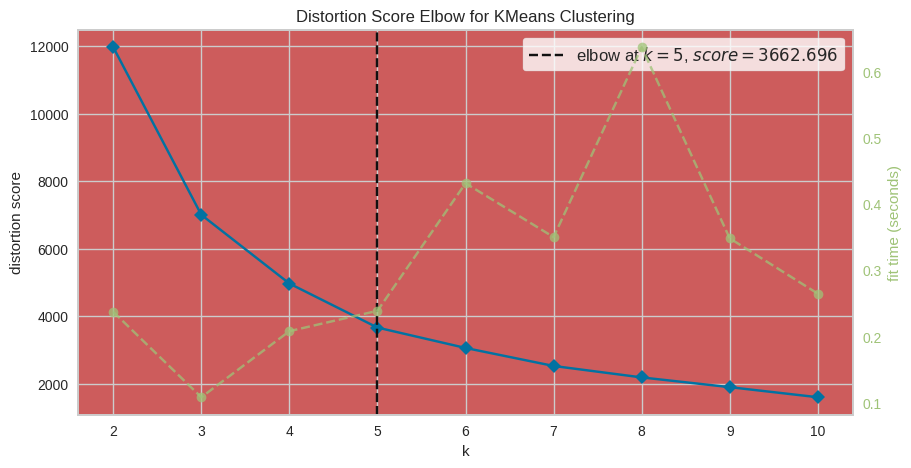

Therefore K = 5


In [ ]:
# Finding initial K value using Elbow Method
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(rfm_cluster_scaled)
Elbow_M.show()
print("Therefore K = 5")

In [ ]:
kmeans = KMeans(n_clusters = 5,max_iter = 50)
kmeans.fit(rfm_cluster_scaled)

KMeans(max_iter=50, n_clusters=5)

In [ ]:
cluster_df['Clusters'] = kmeans.labels_
cluster_df

Recency  Frequency  Monetary  Clusters
Customer ID                                        
17448.0          496         46  14498.47         2
12835.0          427         41   5982.53         2
17850.0          371        155  51080.65         4
12482.0          575         27  20807.00         3
13564.0          353         36  15798.83         2
...              ...        ...       ...       ...
14349.0            9          1    133.50         0
18005.0            3          2    226.47         0
16528.0            3          1    244.41         0
12660.0           10          1    245.10         0
16189.0           15          2    215.48         0

[5833 rows x 4 columns]

In [ ]:
# Centroids of the clusters
kmeans.cluster_centers_

array([[-0.60363726, -0.07929907, -0.06882584],
       [-0.94376143, 15.32754678, 30.24766749],
       [-0.84426232,  1.87959646,  0.91879353],
       [ 1.28492501, -0.31984772, -0.1664163 ],
       [-0.83374672,  9.95598001,  6.71668351]])

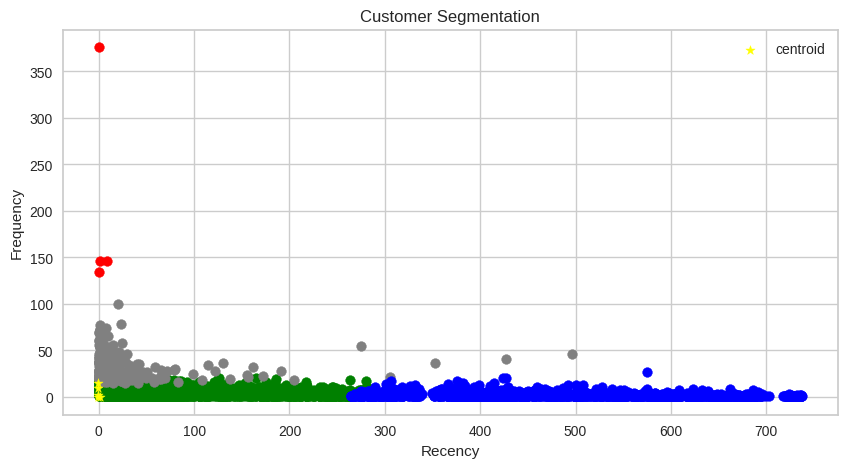

In [ ]:
# grouping the data in accorandance with each cluster seperately
one = cluster_df[cluster_df["Clusters"]==0]
two = cluster_df[cluster_df["Clusters"]==1]
three = cluster_df[cluster_df["Clusters"]==2]
four = cluster_df[cluster_df["Clusters"]==3]
five = cluster_df[cluster_df['Clusters']==4]

#Checking the quality of clustering in the data set
plt.figure(figsize=(10,5))
ax = plt.axes()
plt.scatter(one["Recency"],one["Frequency"],color='green')
plt.scatter(two["Recency"],two["Frequency"],color='red')
plt.scatter(three["Recency"],three["Frequency"],color='grey')
plt.scatter(four["Recency"],four["Frequency"],color='blue')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="yellow",marker="*",label="centroid")
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Customer Segmentation')
plt.legend()
plt.show ()

#### Time Series Forecasting

Check Stationarity:

Plot the time series data to visually inspect trends and seasonality.
Use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [ ]:
# Extracting relevant columns for time series analysis
time_series_data = df[['InvoiceDate', 'Amount']]

# Set 'InvoiceDate' as the index
time_series_data.set_index('InvoiceDate', inplace=True)

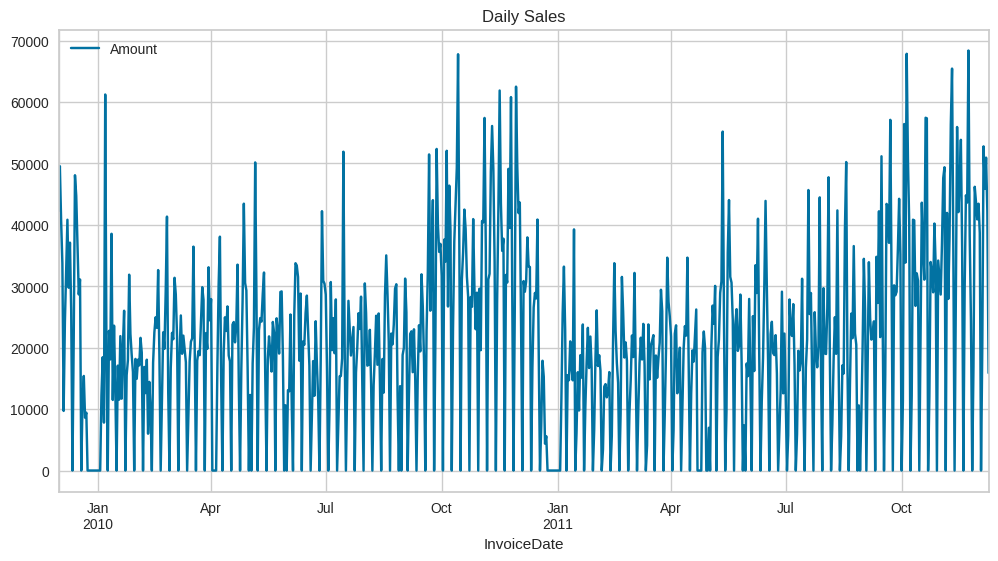

In [ ]:
# Resample data by a specific frequency (e.g., daily)
resampled_data = time_series_data.resample('D').sum()

# Plot the resampled data
resampled_data.plot(figsize=(12, 6), title='Daily Sales')
plt.show()

In [ ]:
def test_stationarity(timeseries):
    # Plot rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    plt.plot(figsize=(12,8))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    # Perform ADF test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

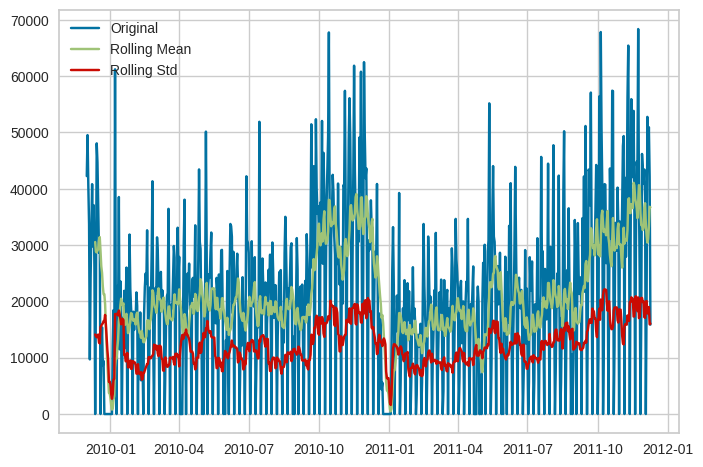

ADF Statistic: -2.621680358099256
p-value: 0.08859865237653525
Critical Values: {'1%': -3.439490435810785, '5%': -2.8655738086413374, '10%': -2.568918067209286}


In [ ]:
# Check stationarity
test_stationarity(resampled_data['Amount'])

ADF Statistic (-2.62) is greater than the critical values at the 1% and 5% levels but less than the critical value at the 10% level.<br>
p-value (0.089) is greater than the common significance level of 0.05.

In [ ]:
# Make the time series stationary through differencing
resampled_data_diff = resampled_data.diff().dropna()

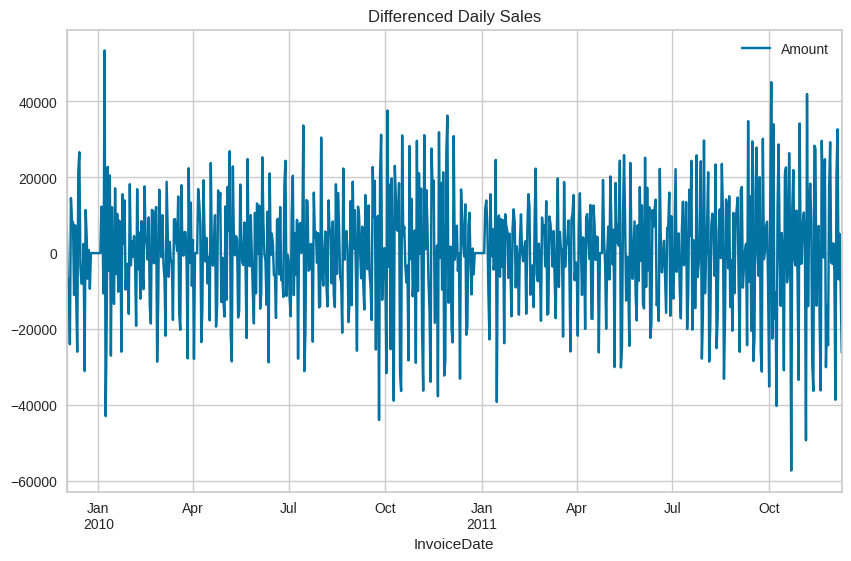

In [ ]:
# Plot the differenced data
resampled_data_diff.plot(figsize=(10, 6), title='Differenced Daily Sales')
plt.show()

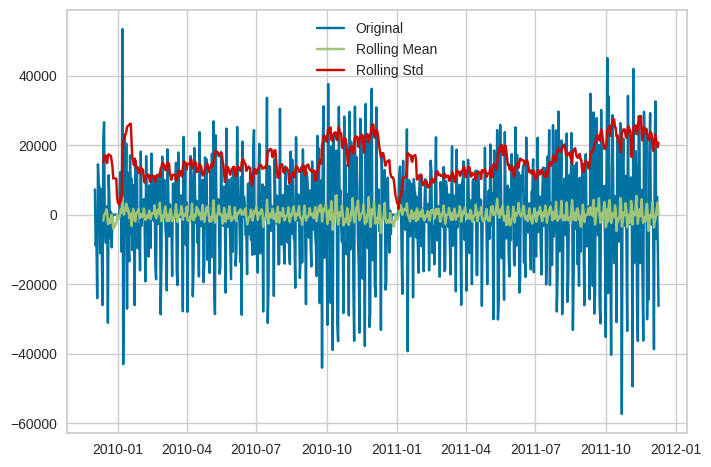

ADF Statistic: -9.811115628741115
p-value: 5.653726242069977e-17
Critical Values: {'1%': -3.439490435810785, '5%': -2.8655738086413374, '10%': -2.568918067209286}


In [ ]:
# Check stationarity again
test_stationarity(resampled_data_diff['Amount'])

ADF Statistic: The ADF Statistic is significantly lower than the critical values at all common significance levels (1%, 5%, 10%). This suggests strong evidence against the null hypothesis of non-stationarity.<br>
p-value: The p-value is extremely small (close to zero), providing strong evidence against the null hypothesis.<br>
**Conclusion** : Based on these results, you can confidently say that the time series is now stationary after differencing.

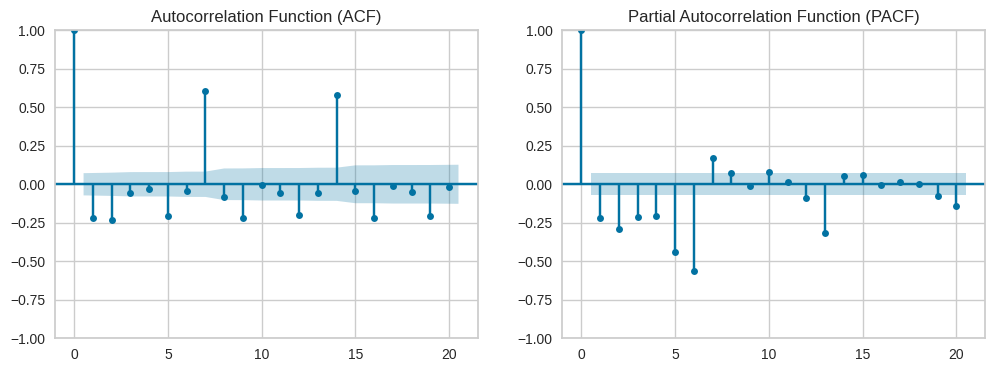

In [ ]:
# Plot ACF and PACF to determine ARIMA parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot
plot_acf(resampled_data_diff, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(resampled_data_diff, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

In [ ]:
# Build ARIMA model
p, d, q = 1, 1, 1  # Adjust parameters based on your plots
model = ARIMA(resampled_data, order=(p, d, q))
results = model.fit()

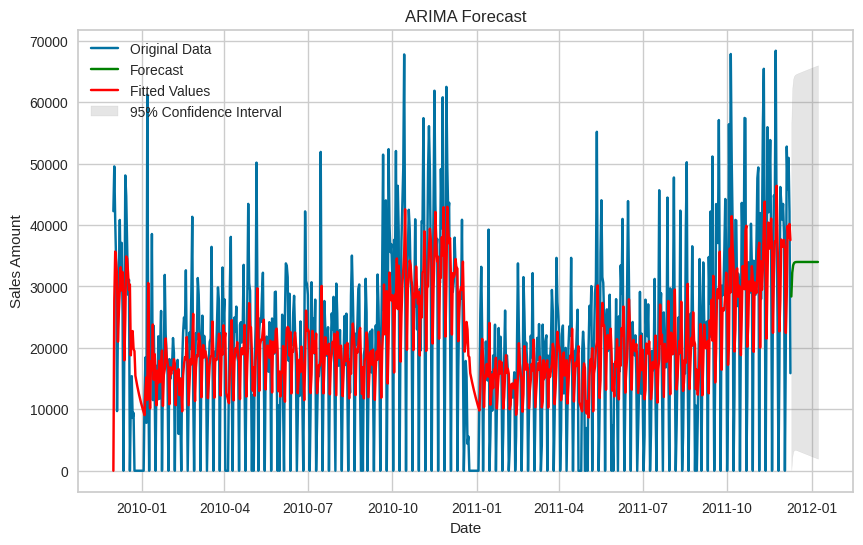

In [ ]:
# Make forecasts
forecast_steps = 30  # Adjust as needed
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean# Visualize results
plt.figure(figsize=(10,6))
plt.plot(resampled_data.index, resampled_data['Amount'], label='Original Data')
plt.plot(forecast_values.index, forecast_values, color='green', label='Forecast')
plt.plot(results.fittedvalues.index, results.fittedvalues, color='red', label='Fitted Values')
# Add confidence intervals
conf_int = forecast.conf_int()
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()